In [1]:
from imports import *

In [2]:
# GLOBAL PARAMETERS

today = datetime.now().strftime('%Y-%m-%d') # For printing/filenames
path = r'C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures'
pdf_path = os.path.join(path, f'{today}_ML_TA_MultipleStocks.pdf')

TICKERS = ["COIN", "TSLA", "GOOGL", "NVDA", "AAPL", "NKE", "SMCI", "XPEV", "NIO", "UNH", "XYZ"]
YEARS_OF_DATA = 2
PROFIT_TARGET = 0.06
STOP_LOSS = 0.05
FORWARD_DAYS = 14 # For prediction
future_window = 14  # Backtesting
tolerance = 1.1

_ms = 7 # global marker size for matplotlib

# Time window
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)

# Shared model components
FEATURES = ['RSI', 'RSI_SMA', 'SMA1', 'SMA2', 'SMA3', 'SMA_Ratio', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band', 'Volume_MA20',
            '5_day_return', '10_day_return', 'Volatility', 'CCI', 'OBV', '+DI', '-DI', 'ADX', 'ATR', 
            'VWMA', 'VI+','VI+', 'KCu','KCl', 'STu', 'STl', 'Candlesticks',
           'Bear', 'Bull', 'vSpike', 'DD']

results = []

In [3]:
# Functions
def get_stock_data(ticker, start_date, end_date):
    #print("Getting data for:   ", ticker)
    df = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1), 
                     interval='1d', auto_adjust=False, progress=False)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df.dropna()
    return df

def add_technical_indicators(df):
    df['SMA1'] = df['Close'].rolling(window=12).mean()
    df['SMA2'] = df['Close'].rolling(window=24).mean()
    df['SMA3'] = df['Close'].rolling(window=52).mean()
    df['SMA_Ratio'] = df['SMA1'] / df['SMA2']
    
    df['Bear'] = (df['SMA1'] < df['SMA2']).astype(int)
    df['Bull'] = (df['SMA2'] < df['SMA1']).astype(int)
    df['RSI']= ta.calculate_rsi(df)
    df['RSI_SMA'] = df['RSI'] / df['RSI'].rolling(14).mean()
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=24, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['vSpike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
    
    df['CCI'] = ta.calculate_cci(df)
    df['OBV'] = ta.calculate_obv(df)
    df[['+DI', '-DI', 'ADX']] = ta.calculate_dmi(df, n=14)
    df['ATR'] = ta.calculate_atr(high=df.High, low=df.Low, close=df.Close)
    
    df['VWMA'] = ta.calculate_vwma(df)
    df[['KCm', 'KCu', 'KCl']] = ta.calculate_keltner(df)
    df[['VI+', 'VI-']] = ta.calculate_vortex(df)
    df[['STu', 'STl']] = ta.calculate_supertrend(df)
    
    df = ta.add_candlestickpatterns(df)
    
    df['DD'] = df['Close'].where(df['Close'] < df['Close'].shift(1)).std()

    df['5_day_return'] = df['Close'].pct_change(5)
    df['10_day_return'] = df['Close'].pct_change(10)
    df['Volatility'] = df['Close'].rolling(14).std()
    
    return df

def compute_expected_return(df):
    df['5_day_return'] = df['Close'].pct_change(int(FORWARD_DAYS/2))
    df['10_day_return'] = df['Close'].pct_change(FORWARD_DAYS)
    df['Volatility'] = df['Close'].rolling(FORWARD_DAYS).std()
    df['Expected_Return'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(close_prices) - FORWARD_DAYS):
        current_price = close_prices[i]
        future_max = np.nanmax(close_prices[i + 1:i + 1 + FORWARD_DAYS])
        expected_return = (future_max - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Return')] = expected_return
    return df

def compute_expected_loss(df):
    df['Expected_Loss'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(close_prices) - FORWARD_DAYS):
        current_price = close_prices[i]
        future_min = np.nanmin(close_prices[i + 1:i + 1 + FORWARD_DAYS])
        expected_loss = (future_min - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Loss')] = expected_loss
    return df

def add_lagged_features(df, lags=[1, 2, 3]):
    for lag in lags:
        for feature in FEATURES:
            if feature in df.columns:
                df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

def initialize_XGBR():
    model = XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    return model
def label_tp_hit(df, window=14, profit_target=0.03, stop_loss=0.03):
    """
    Label each row:
    1 = TP hit before SL
    0 = SL hit before TP or neither hit
    """
    labels = []
    close_prices = df['Close'].values

    for i in range(len(close_prices) - window):
        current_price = close_prices[i]
        tp = current_price * (1 + profit_target)
        sl = current_price * (1 - stop_loss)
        future_prices = close_prices[i + 1:i + 1 + window]

        tp_hit_idx = next((j for j, price in enumerate(future_prices) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(future_prices) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(1)
        else:
            labels.append(0)

    # Fill remaining with NaN to keep alignment
    labels += [np.nan] * window
    df['TP_Hit_Label'] = labels
    return df

def compute_optimal_entry(df, forward_days=10, profit_target=0.05, stop_loss=-0.03):
    optimal_entries = []
    
    for i in range(len(df) - forward_days):
        entry_price = df['Close'].iloc[i]
        future_data = df.iloc[i+1:i+1+forward_days]
        
        min_price = future_data['Low'].min()  # Best possible entry
        max_price = future_data['High'].max()  # Highest possible gain

        # Check if TP or SL hit
        tp_price = entry_price * (1 + profit_target)
        sl_price = entry_price * (1 + stop_loss)

        tp_hit = (future_data['High'] >= tp_price).any()
        sl_hit = (future_data['Low'] <= sl_price).any()

        if tp_hit and not sl_hit:
            optimal_entry = min_price  # You had time to enter lower before TP
        elif sl_hit and not tp_hit:
            optimal_entry = entry_price  # Didn't get a better chance
        elif tp_hit and sl_hit:
            # Whichever came first
            first_tp_idx = future_data[future_data['High'] >= tp_price].index[0]
            first_sl_idx = future_data[future_data['Low'] <= sl_price].index[0]
            optimal_entry = min_price if first_tp_idx < first_sl_idx else entry_price
        else:
            optimal_entry = entry_price  # No TP/SL hit, assume flat

        optimal_entries.append(optimal_entry)

    # Align with DataFrame length
    df['Optimal_Entry'] = [np.nan]*forward_days + optimal_entries
    return df

def compute_expected_entry(df, n=3):
    df['Expected_Entry'] = df['Low'].rolling(window=n, min_periods=1).min().shift(-n)
    return df
    
def label_tp_hit(df, window=14, profit_target=0.03, stop_loss=0.03):
    """
    Label each row:
    1 = TP hit before SL
    0 = SL hit before TP or neither hit
    """
    labels = []
    close_prices = df['Close'].values

    for i in range(len(close_prices) - window):
        current_price = close_prices[i]
        tp = current_price * (1 + profit_target)
        sl = current_price * (1 - stop_loss)
        future_prices = close_prices[i + 1:i + 1 + window]

        tp_hit_idx = next((j for j, price in enumerate(future_prices) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(future_prices) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(1)
        else:
            labels.append(0)

    # Fill remaining with NaN to keep alignment
    labels += [np.nan] * window
    df['TP_Hit_Label'] = labels
    return df

def plot_single_ticker(ticker, df, df_results, future_window=14):
    # Get predictions
    predictions = df_results[df_results['Ticker'] == ticker].iloc[0]
    
    # Create figure with white background
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), dpi = 300, height_ratios=[3, 1], sharex=True)
    fig.patch.set_facecolor('white')
    
    # Get true trailing 12 months of data (not calendar YTD)
    end_date = df.index[-1]
    start_date = end_date - pd.DateOffset(months=12)
    df = df.loc[start_date:end_date]
    last_date = df.index[-1]
    current_price = round(df['Close'].iloc[-1], 2)
    
    # ===== 1. PRICE PLOT =====
    # Configure plot style
    ax1.set_facecolor('white')
    ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Historical data
    ax1.plot(df.index, df['Close'].rolling(3).mean(), label='Price', color='gray', alpha=0.7, linewidth=1.5)
    ax1.plot(df.index, df['SMA1'], label='SMA Short', color='gold', alpha=0.7, linewidth=1.2)
    ax1.plot(df.index, df['SMA2'], label='SMA Long', color='red', alpha=0.7, linewidth=1.2, linestyle='--')
    
    # Fill between SMAs - green when SMA1 > SMA2, red otherwise
    ax1.fill_between(df.index, df['SMA1'], df['SMA2'],
                    where=(df['SMA1'] > df['SMA2']),
                    facecolor='green', alpha=0.1, interpolate=True)
    
    ax1.fill_between(df.index, df['SMA1'], df['SMA2'],
                    where=(df['SMA1'] <= df['SMA2']),
                    facecolor='red', alpha=0.1, interpolate=True)
    
    # Future projections
    future_date = last_date + pd.Timedelta(days=future_window)
    gain_price = current_price * (1 + predictions['Max (%)']/100)
    loss_price = current_price * (1 + predictions['Loss (%)']/100)
    avg_price = (current_price+loss_price)/2.
    
    # Connect lines
    ax1.plot([last_date, future_date], [avg_price, gain_price], 
             color='green', linestyle=':', linewidth=1.5, alpha=0.5)
    ax1.plot([last_date, future_date], [avg_price, loss_price], 
             color='red', linestyle=':', linewidth=1.5, alpha=0.5)
    
    # Markers For Key levels
    ax1.plot(future_date, gain_price, '^', markersize=_ms, color='green', alpha=0.5, label='Projected Gain')
    ax1.plot(future_date, loss_price, 'v', markersize=_ms, color='red', alpha=0.5, label='Projected Loss')
    ax1.plot(last_date, avg_price, 'o', markersize=_ms, color='orange', alpha=0.5, label='Entry')


    ax1.annotate(f'Avg: ${avg_price:.1f}', 
                xy=(last_date, avg_price),
                xytext=(10, 0),  # 10 points to the right of the marker
                textcoords='offset points',
                ha='left', 
                va='center',
                color='orange',
                fontsize=9,
                bbox=dict(facecolor='white', 
                         alpha=0.5, 
                         edgecolor='none'))
    
    ax1.annotate(f'${current_price}\t-\t${gain_price:.1f}\n+{predictions["Max (%)"]:.1f}%', 
                xy=(future_date, gain_price),
                xytext=(10, 10), textcoords='offset points',
                ha='left', va='bottom', color='green', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    ax1.annotate(f'${current_price}\t-\t${loss_price:.1f}\n{predictions["Loss (%)"]:.1f}%', 
                xy=(future_date, loss_price),
                xytext=(10, -10), textcoords='offset points',
                ha='left', va='top', color='red', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))

    signal_color = 'green' if 'Bullish' in predictions['Signal'] else 'red' if 'Bearish' in predictions['Signal'] else 'gray'
    ax1.annotate(predictions['Signal'], 
                 xy=(0.7, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 fontsize=12, weight='bold',
                 bbox=dict(boxstyle='round', 
                          facecolor=signal_color, 
                          alpha=0.2,  # Slight transparency
                          edgecolor=signal_color))

    # Add ticker name in the middle
    ax1.text(0.5, 0.5, f'@{ticker}', transform=ax1.transAxes, 
                 fontsize=50, color='grey', alpha=0.2,
                 horizontalalignment='center', verticalalignment='center',
                 rotation=0, weight='bold', style='italic')

    textbox = AnchoredText(
       f'Buy closer to predicted SL: ${loss_price:.2f} to reduce risk\nand increase chance of success.',
       loc='lower right',
       frameon=True,
       borderpad=1.5,
       prop=dict(size=7, color='red', weight='bold')
    )
    
    # Set the box properties through the patch
    textbox.patch.set(facecolor='white', edgecolor='gray', alpha=0.5, boxstyle='round')
    
    ax1.add_artist(textbox)

    # Move y-axis to right
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")
    ax1.set_ylabel('Price')
    ax1.set_title(f'{today}: \t{ticker} - {predictions["Signal"]}', pad=20)
    ax1.legend(loc='upper left')
    
    # ===== 2. RSI PLOT =====
    ax2.set_facecolor('white')
    rsi_ = df['RSI'].rolling(3).mean()
    ax2.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax2.plot(df.index, rsi_, label='RSI', color='gray', linewidth=1.5, alpha=0.7)
    ax2.plot(df.index, df['RSI'].rolling(20).mean(), label='RSI SMA', color='gold', linewidth=1.2, alpha=0.7)

    # Fill RSI above 52 (green) and below 40 (red)
    ax2.fill_between(df.index, rsi_, 52,
                    where=(df['RSI'] > 52),
                    facecolor='green', alpha=0.1)
    ax2.fill_between(df.index, rsi_, 40,
                    where=(df['RSI'] < 40),
                    facecolor='red', alpha=0.1)
    
    ax2.axhline(70, color='green', linestyle='--', alpha=0.2)
    ax2.axhline(30, color='red', linestyle='--', alpha=0.2)
    ax2.axhline(50, color='black', linestyle='-', alpha=0.2)
    ax2.set_ylim(0, 100)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    
    # Formatting
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()
    
    # Save the figure to disk
    fname = f'{today}_{ticker}_TPSL.png'
    fpath = os.path.join(path, fname)
    plt.savefig(fpath, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

#df_ticker = get_stock_data(stock, datetime.now()-timedelta(days=365), datetime.now())
#df_ticker = add_technical_indicators(df_ticker)
#plot_single_ticker(stock, df_ticker, df_results)

In [4]:
# Make Predictions (Gain/Loss/Confidence)
for ticker in TICKERS:
    try:
        df = get_stock_data(ticker, start_date, end_date)
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
        df = add_technical_indicators(df)
        df = compute_expected_return(df)
        df = compute_expected_loss(df)  # Add loss calculation

        df = label_tp_hit(df, window=FORWARD_DAYS, profit_target=PROFIT_TARGET, stop_loss=STOP_LOSS)
        df_model = df.dropna(subset=FEATURES + ['TP_Hit_Label', 'Expected_Return', 'Expected_Loss'])
        
        if len(df_model) < 50:
            continue

        # Train return model
        X = df_model[FEATURES]
        y_return = df_model['Expected_Return']
        scaler_return = StandardScaler()
        X_scaled_return = scaler_return.fit_transform(X)
        
        # ✅ Split the data
        X_train_ret, X_val_ret, y_train_ret, y_val_ret = train_test_split(X_scaled_return, y_return, test_size=0.2, random_state=42)
        
        model_return = RandomForestRegressor(
        n_estimators=200,         
        max_depth=10,               
        min_samples_leaf=5,        
        max_features='sqrt',       
        ccp_alpha=0.01               
        )
        
        model_return.fit(X_train_ret, y_train_ret)
        
        #print(f"{ticker} Return R²:", model_return.score(X_val_ret, y_val_ret))

        # Train loss model
        y_loss = df_model['Expected_Loss']
        scaler_loss = StandardScaler()
        X_scaled_loss = scaler_loss.fit_transform(X)
        
        X_train_loss, X_val_loss, y_train_loss, y_val_loss = train_test_split(X_scaled_loss, y_loss, test_size=0.2, random_state=42)
        
        model_loss = RandomForestRegressor(
        n_estimators=200,         
        max_depth=10,               
        min_samples_leaf=5,        
        max_features='sqrt',       
        ccp_alpha=0.01               
        )
        model_loss.fit(X_train_loss, y_train_loss)

        y_class = df_model['TP_Hit_Label'].astype(int)
        
        X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(X_scaled_return, y_class, test_size=0.2, random_state=42)

        model_class = RandomForestClassifier(
            n_estimators=200, 
            max_depth=10,
            min_samples_leaf=5, 
            random_state=42
        )
        
        model_class.fit(X_train_cls, y_train_cls)

        latest = df.iloc[[-1]]
        if latest[FEATURES].isnull().values.any():
            continue
            
        # Predict both return and loss
        latest_scaled_return = scaler_return.transform(latest[FEATURES])
        latest_scaled_loss = scaler_loss.transform(latest[FEATURES])
        predicted_return = model_return.predict(latest_scaled_return)[0]
        predicted_loss = model_loss.predict(latest_scaled_loss)[0]

        entry_price = latest['Close'].values[0]
        predicted_tp = entry_price * (1 + predicted_return)
        predicted_sl = entry_price * (1 + predicted_loss)
        
        best_rr = -np.inf
        best_entry = entry_price
        for discount in [0.005, 0.01, 0.015, 0.02, 0.025]:
            candidate_entry = entry_price *(1-discount)
            rr = (predicted_tp - candidate_entry) / abs(predicted_sl - candidate_entry)
            if rr > best_rr:
                best_rr = rr
                best_entry = candidate_entry
        
        entry_discount_pct = ((best_entry-entry_price) / entry_price) * 100
        
        latest_scaled_class = scaler_return.transform(latest[FEATURES])
        tp_hit_prob = model_class.predict_proba(latest_scaled_class)[0][1]
        confidence_score = tp_hit_prob * max(predicted_return / abs(predicted_loss), 0)

        # Technical condition check
        current_price = latest['Close'].values[0]
        sma1 = latest['SMA1'].values[0]
        sma2 = latest['SMA2'].values[0]
        rsi = latest['RSI'].values[0]

        signal = "⚠️ Neutral"
        if (current_price >= sma1 and sma1 >= sma2 and rsi >= 52):
            signal = "✅ Bullish"
            if predicted_return > abs(predicted_loss) and tp_hit_prob > 0.5:
                entry_signal = True
        elif(current_price <= sma1 and sma1 <= sma2 and rsi <= 48):
            signal = "🔻 Bearish"
            entry_signal = False
        else:
            signal = "⚠️ Neutral"
            entry_signal = False
        
        def colored_row(text, color):
            colors = {
                'green': '\033[92m',  # Bright green for better visibility
                'red': '\033[91m',    # Bright red
                'white': '\033[97m'   # Bright white
            }
            return f"{colors.get(color, '')}{text}\033[0m"
        
        # Determine color based on signal
        sc = 'green' if (signal == "✅ Bullish" and confidence_score >= 0.5) else 'red' if signal == "🔻 Bearish" else 'white'
        
        # Apply color to the ENTIRE row at once
        row_text = f'Trained Model for {ticker}\t\t${current_price:.2f}\t{signal}\tConfidence: {int(confidence_score*100)}%'
        print(colored_row(row_text, sc))

        results.append({
            "Ticker": ticker,
            "Date": latest.index[-1].date(),
            "Price": round(entry_price, 1),
            "Entry": round(best_entry, 1),
            "Entry%": round(entry_discount_pct, 1),
            "Max (%)": round(predicted_return * 100, 1),
            "TP": round(predicted_tp, 1),
            "SL": round(predicted_sl, 1),
            "Loss (%)": round(predicted_loss * 100, 1),
            "Signal": signal,
            "Risk": "🔴 High Risk" if abs(predicted_loss) > STOP_LOSS else "🟢 Low Risk",
            "TP_Prob": round(tp_hit_prob * 100, 1),
            "Confidence": round(confidence_score*100, 1),
        })

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        
# TABULAR Display
df_results = pd.DataFrame(results)

Trained Model for COIN		$355.80	✅ Bullish	Confidence: 60%
Trained Model for TSLA		$315.35	⚠️ Neutral	Confidence: 60%
Trained Model for GOOGL		$179.53	✅ Bullish	Confidence: 56%
Trained Model for NVDA		$159.34	✅ Bullish	Confidence: 39%
Trained Model for AAPL		$213.55	✅ Bullish	Confidence: 10%
Trained Model for NKE		$76.39	✅ Bullish	Confidence: 21%
Trained Model for SMCI		$48.56	✅ Bullish	Confidence: 23%
Trained Model for XPEV		$18.85	⚠️ Neutral	Confidence: 72%
Trained Model for NIO		$3.51	⚠️ Neutral	Confidence: 33%
Trained Model for UNH		$308.55	⚠️ Neutral	Confidence: 37%
Trained Model for XYZ		$69.23	✅ Bullish	Confidence: 59%


In [5]:
# Tabulate Data
_df = pd.DataFrame(results).sort_values(by="Confidence", ascending=False)
print("\n=== Multi-Ticker Prediction Table (Modified) ===")
print(tabulate(_df, headers='keys', tablefmt='table'))


=== Multi-Ticker Prediction Table (Modified) ===
    Ticker    Date          Price    Entry    Entry%    Max (%)     TP     SL    Loss (%)  Signal      Risk            TP_Prob    Confidence
--  --------  ----------  -------  -------  --------  ---------  -----  -----  ----------  ----------  ------------  ---------  ------------
 7  XPEV      2025-07-03     18.9     18.4      -2.5       12.5   21.2   17.3        -8.3  ⚠️ Neutral  🔴 High Risk       47.8          72.1
 1  TSLA      2025-07-03    315.4    307.5      -2.5       10.2  347.5  289.1        -8.3  ⚠️ Neutral  🔴 High Risk       49.8          61
 0  COIN      2025-07-03    355.8    346.9      -2.5       15.7  411.5  326          -8.4  ✅ Bullish  🔴 High Risk       32.4          60.6
10  XYZ       2025-07-03     69.2     67.5      -2.5        7.7   74.6   64.8        -6.4  ✅ Bullish  🔴 High Risk       49.1          59.2
 2  GOOGL     2025-07-03    179.5    175        -2.5        4.5  187.7  173.1        -3.6  ✅ Bullish  🟢 Low Risk

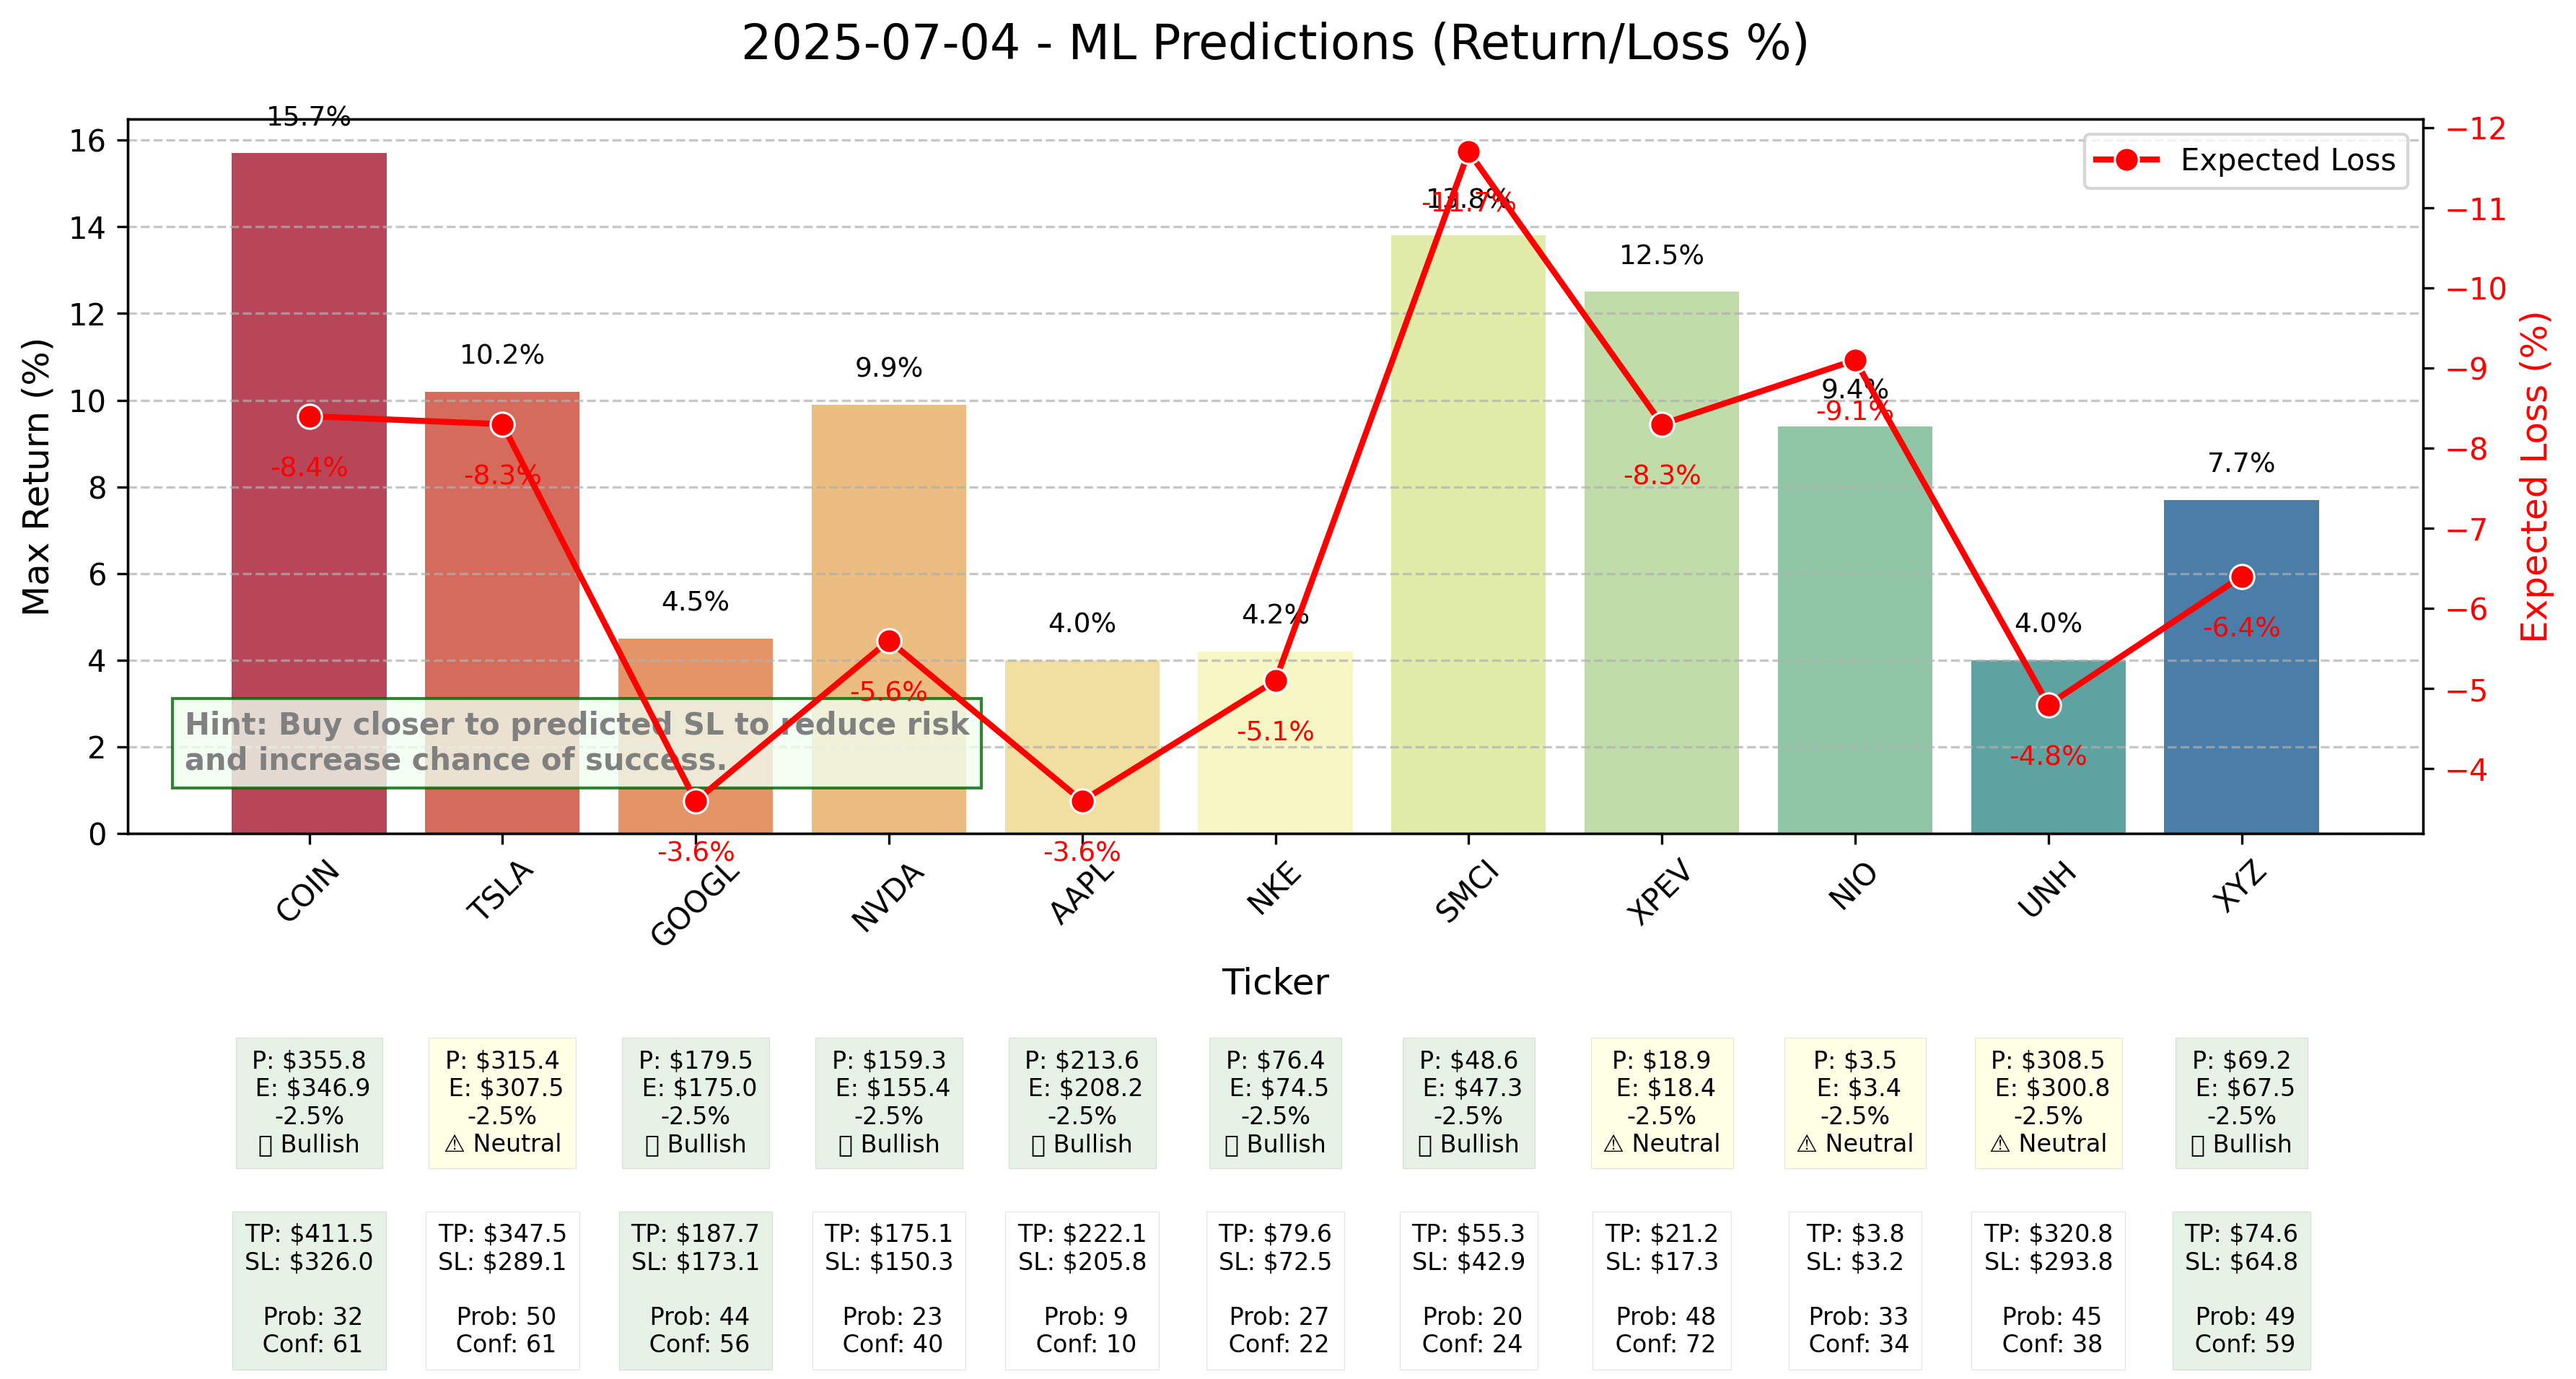

In [6]:
# ✅ PLOT PREDICTIONS
df_plot = df_results

# Create figure with adjusted bottom margin
fig, ax1 = plt.subplots(figsize=(12, 6), zorder=1, dpi = 300)

# --- MAIN PLOT (original styling) ---
sns.barplot(x="Ticker", y="Max (%)", data=df_plot, palette="Spectral", ax=ax1)
ax1.set_ylabel('Max Return (%)', fontsize=12)
ax1.set_xlabel('Ticker', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# --- SECONDARY AXIS (original styling) ---
ax2 = ax1.twinx()
sns.lineplot(x="Ticker", y="Loss (%)", data=df_plot, color='red', marker='o', 
             ax=ax2, linewidth=2, markersize=8, label='Expected Loss')
ax2.set_ylabel('Expected Loss (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()

# --- FIXED ANNOTATION POSITIONS ---
for i, (_, row) in enumerate(df_plot.iterrows()):
    
    # Updated color assignment for three signal types
    fcolor = (
        'green' if row.Signal == "✅ Bullish" 
        else 'red' if row.Signal == "🔻 Bearish"
        else 'yellow'  # Neutral case
    )
    ProbColor = 'green' if (row.Signal == "✅ Bullish" and row.Confidence > 40) else 'white'
        
    # Top annotations (unchanged)
    ax1.text(i, row["Max (%)"] + 0.5, f'{row["Max (%)"]:.1f}%', 
             ha='center', va='bottom', fontsize=9)
    ax2.text(i, row["Loss (%)"] + 0.5, f'{row["Loss (%)"]:.1f}%', 
             ha='center', va='top', color='red', fontsize=9)
    
    # Bottom annotations (FIXED)
    vertical_offset = 5  # Base offset in percentage points
    off1 = vertical_offset + 4 # Additional space for Entry box
    off2 = vertical_offset # TP/SL at base offset
    
    ax1.text(i, -off2, 
             f'P: ${row["Price"]:.1f}\n E: ${row["Entry"]:.1f}\n{row["Entry%"]:.1f}%\n{row["Signal"]}',
             ha='center', va='top', fontsize=8, 
             bbox=dict(facecolor=fcolor, alpha=0.1, linewidth=0.3))
    
    ax1.text(i, -off1, 
             f'TP: ${row["TP"]:.1f}\nSL: ${row["SL"]:.1f}\n\n Prob: {row["TP_Prob"]:.0f}\n Conf: {row["Confidence"]:.0f}', 
             ha='center', va='top', fontsize=8, 
             bbox=dict(facecolor = ProbColor, alpha=0.1, linewidth=0.3))

# --- STRATEGIC HINT (original position but padded) ---
textbox = AnchoredText(
    "Hint: Buy closer to predicted SL to reduce risk\nand increase chance of success.",
    loc='lower left',
    frameon=True,
    borderpad=1.5,  # Increased padding
    prop=dict(size=10, color='gray', weight='bold')
)

ax1.add_artist(textbox)
textbox.set_clip_on(True)
textbox.set_in_layout(True)
textbox.set_zorder(100)
textbox.patch.set_facecolor('honeydew')
textbox.patch.set_edgecolor('darkgreen')
textbox.patch.set_alpha(0.8)

# --- FINAL SPACE MANAGEMENT ---
plt.title(f'{today} - ML Predictions (Return/Loss %)', fontsize=16, pad=20)
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)  # Increased from default to protect x-labels

# Save the figure to disk
fname = f'{today}_ML_PNL_MultiStocks.png'
fpath = os.path.join(path, fname)
plt.savefig(fpath, bbox_inches='tight')
plt.show()


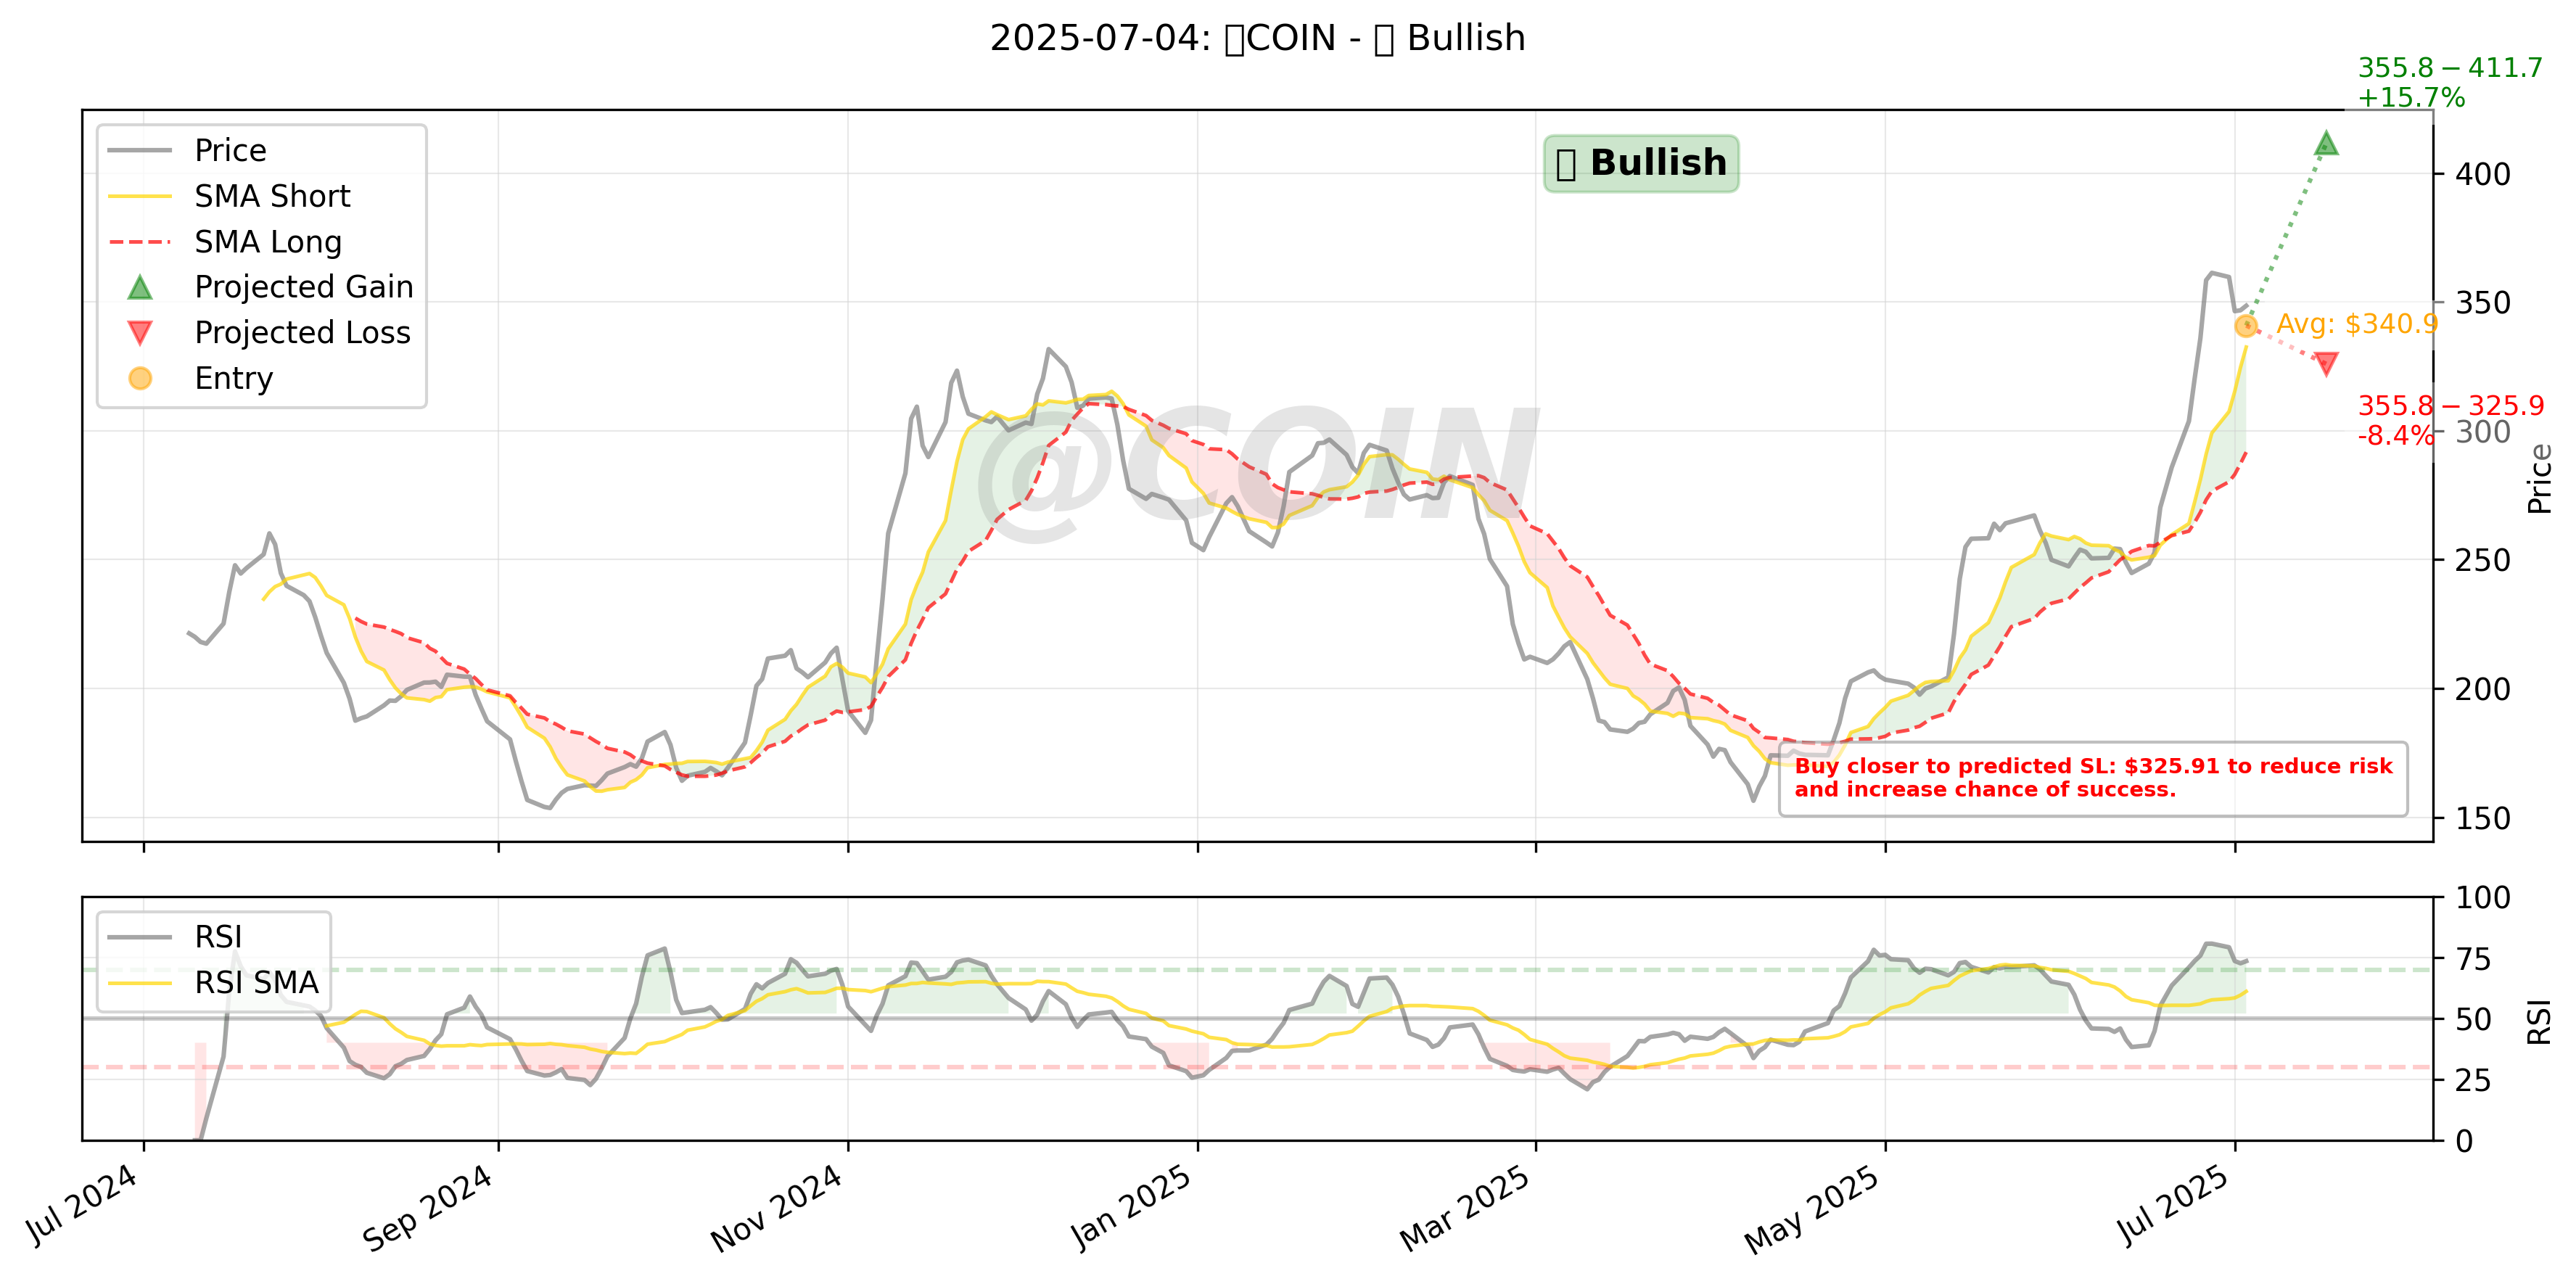

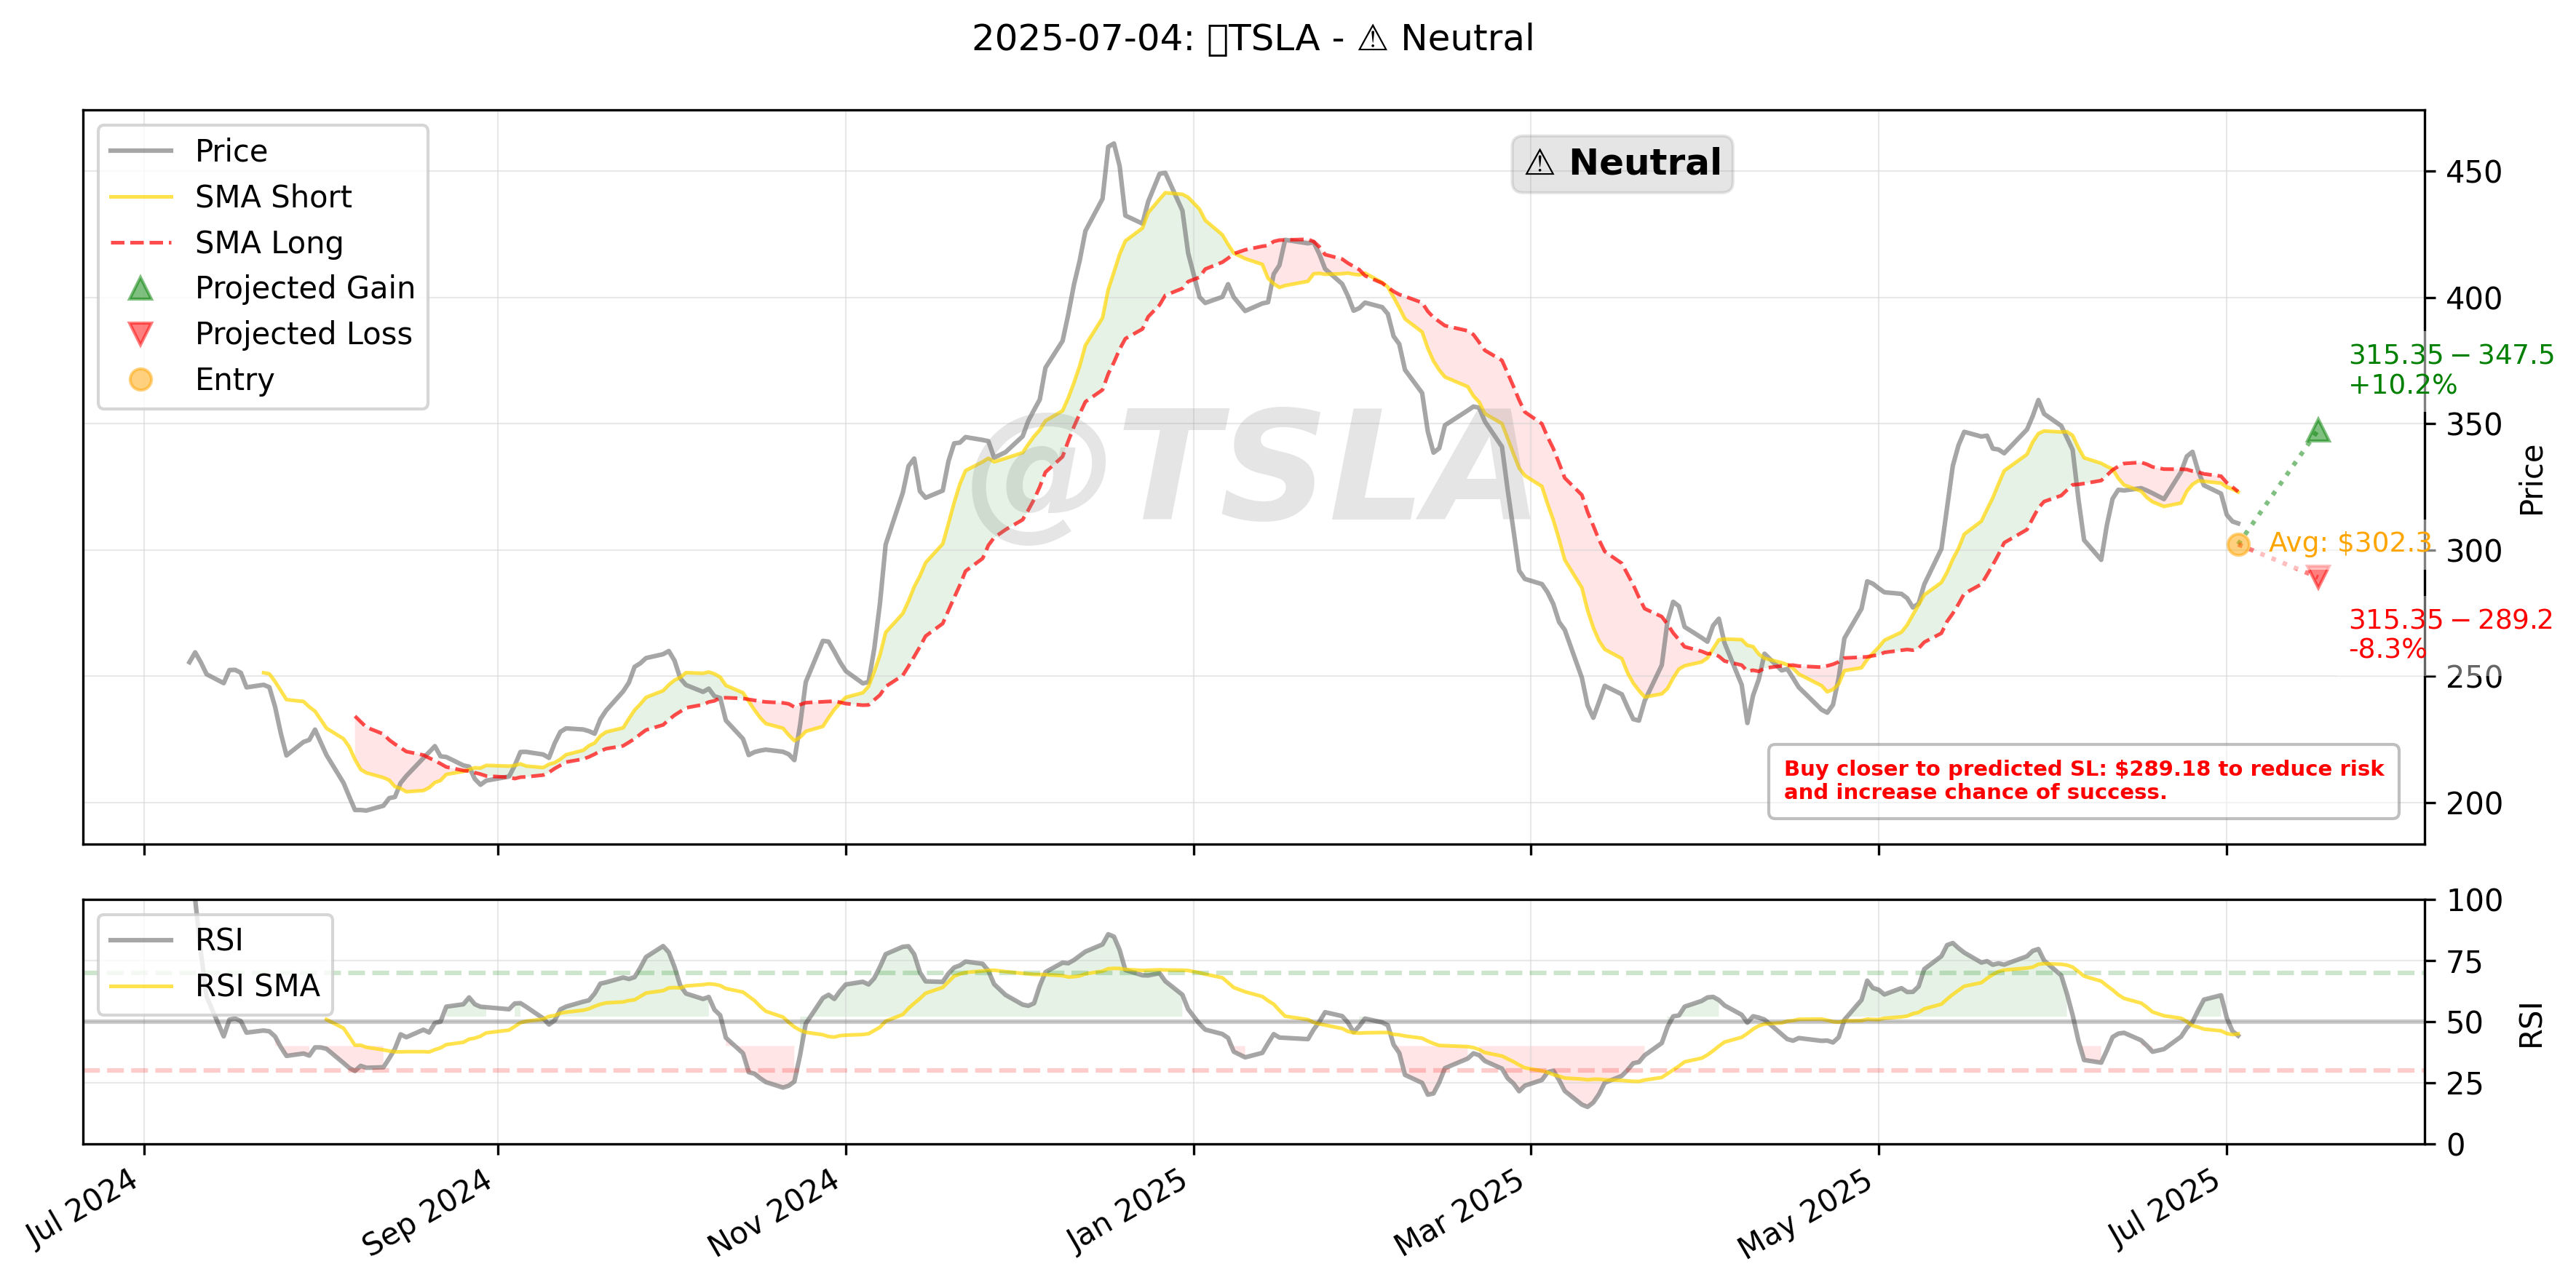

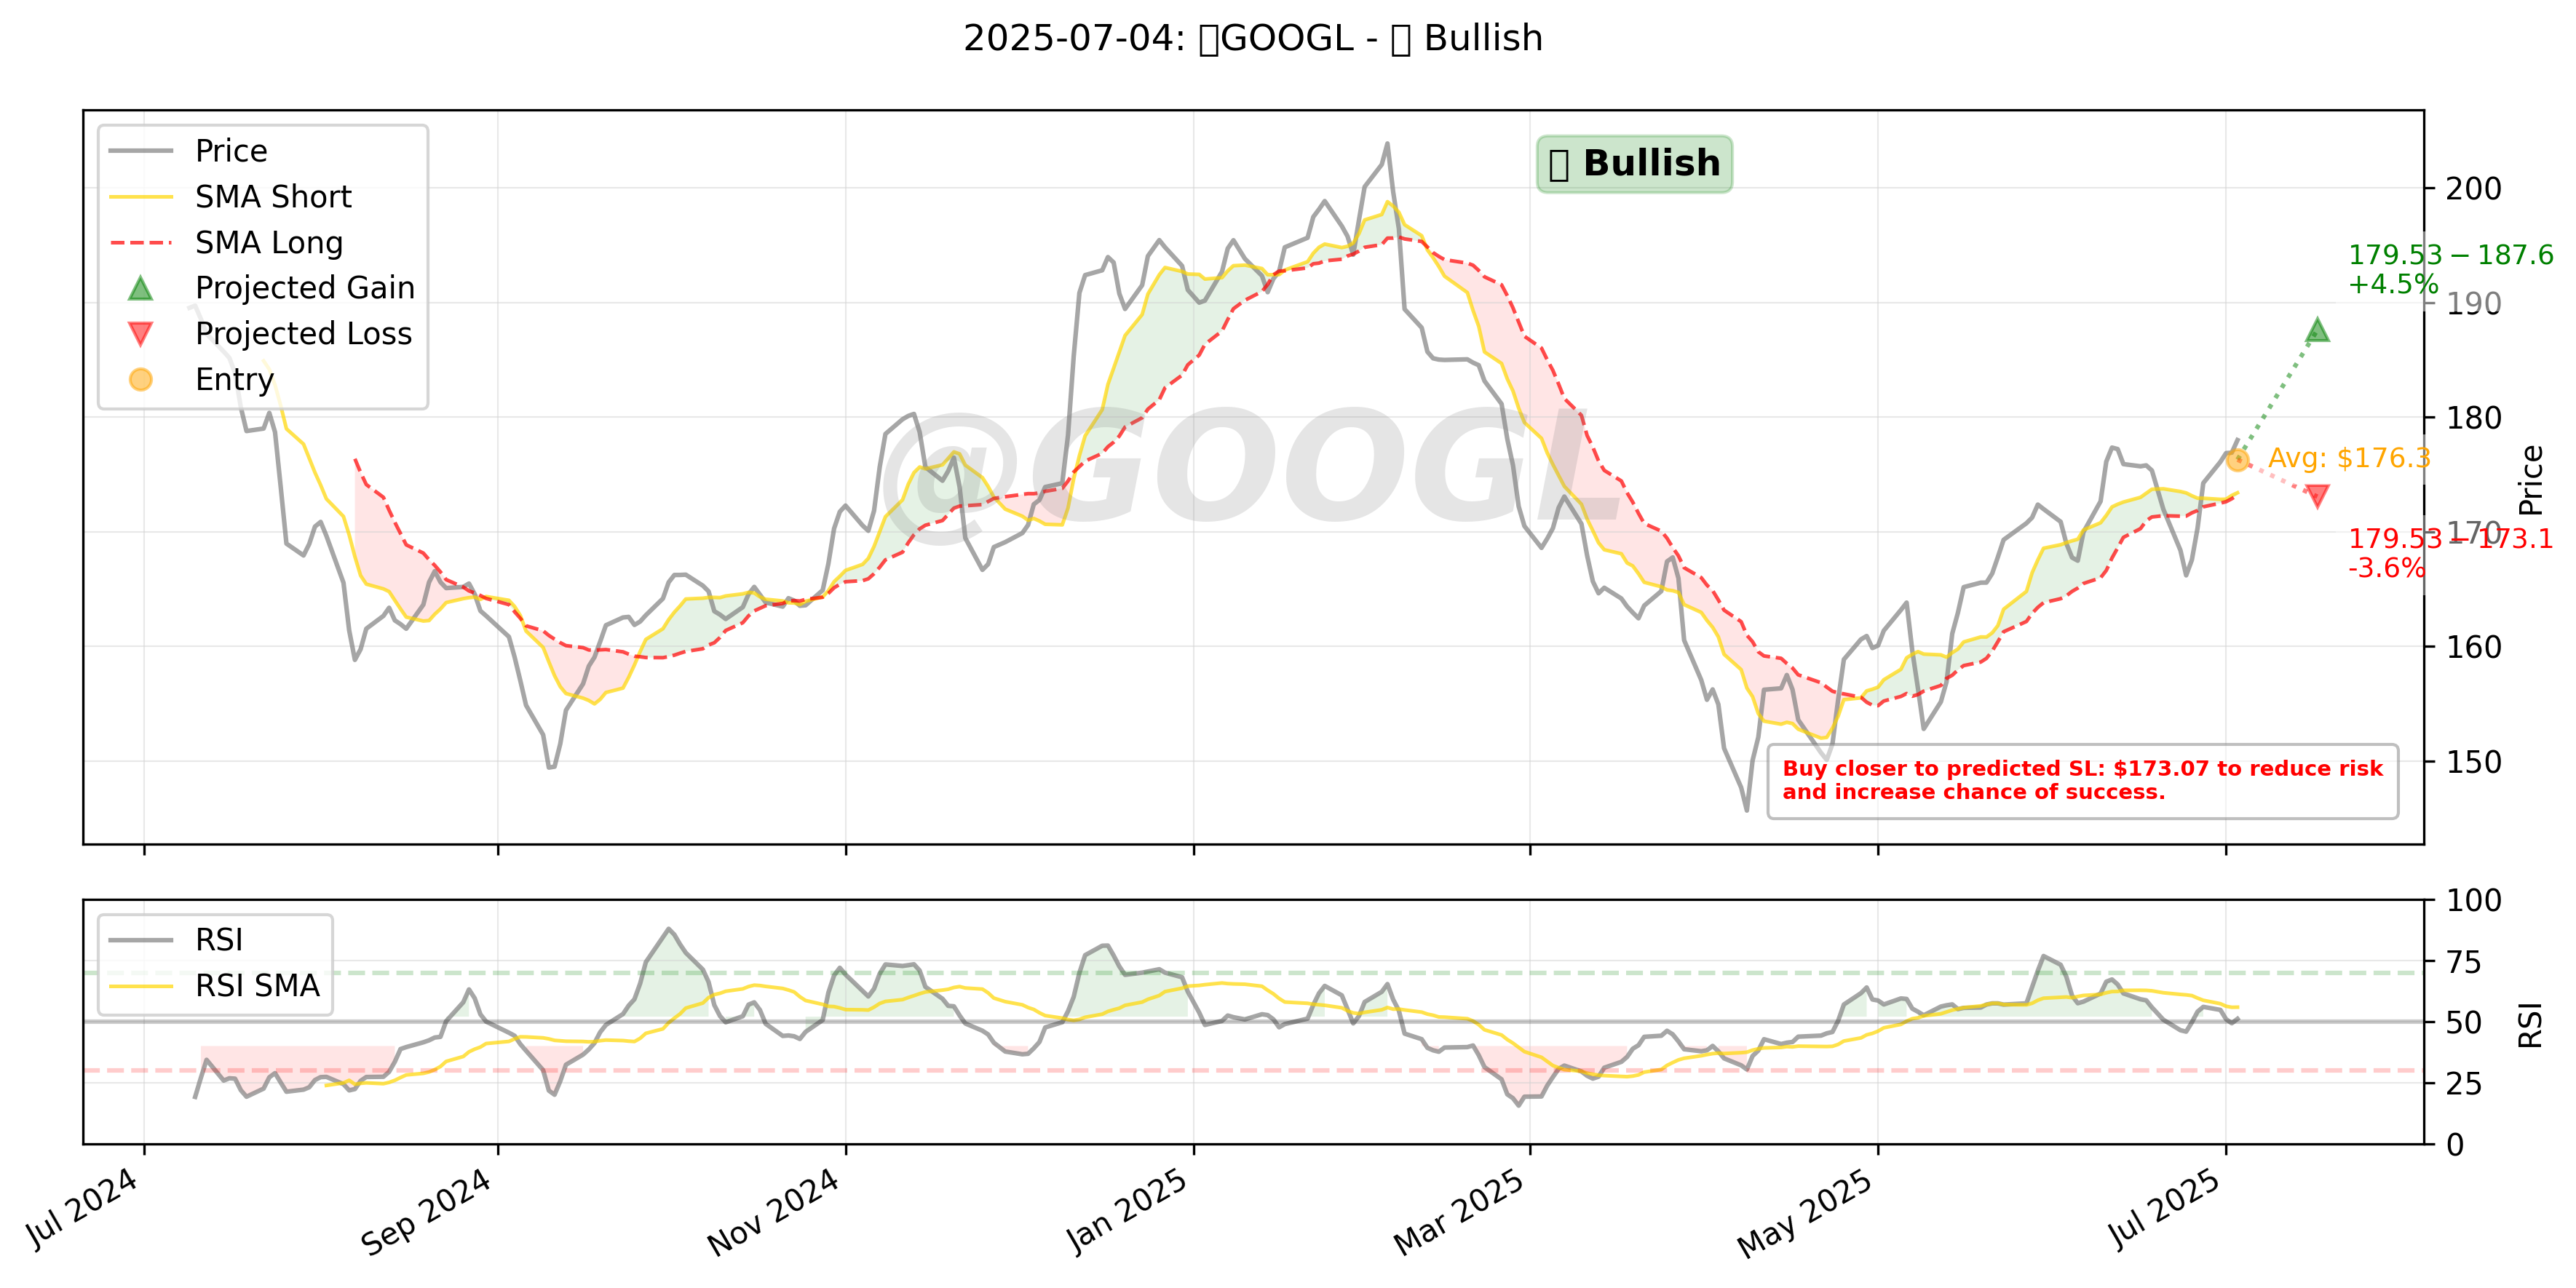

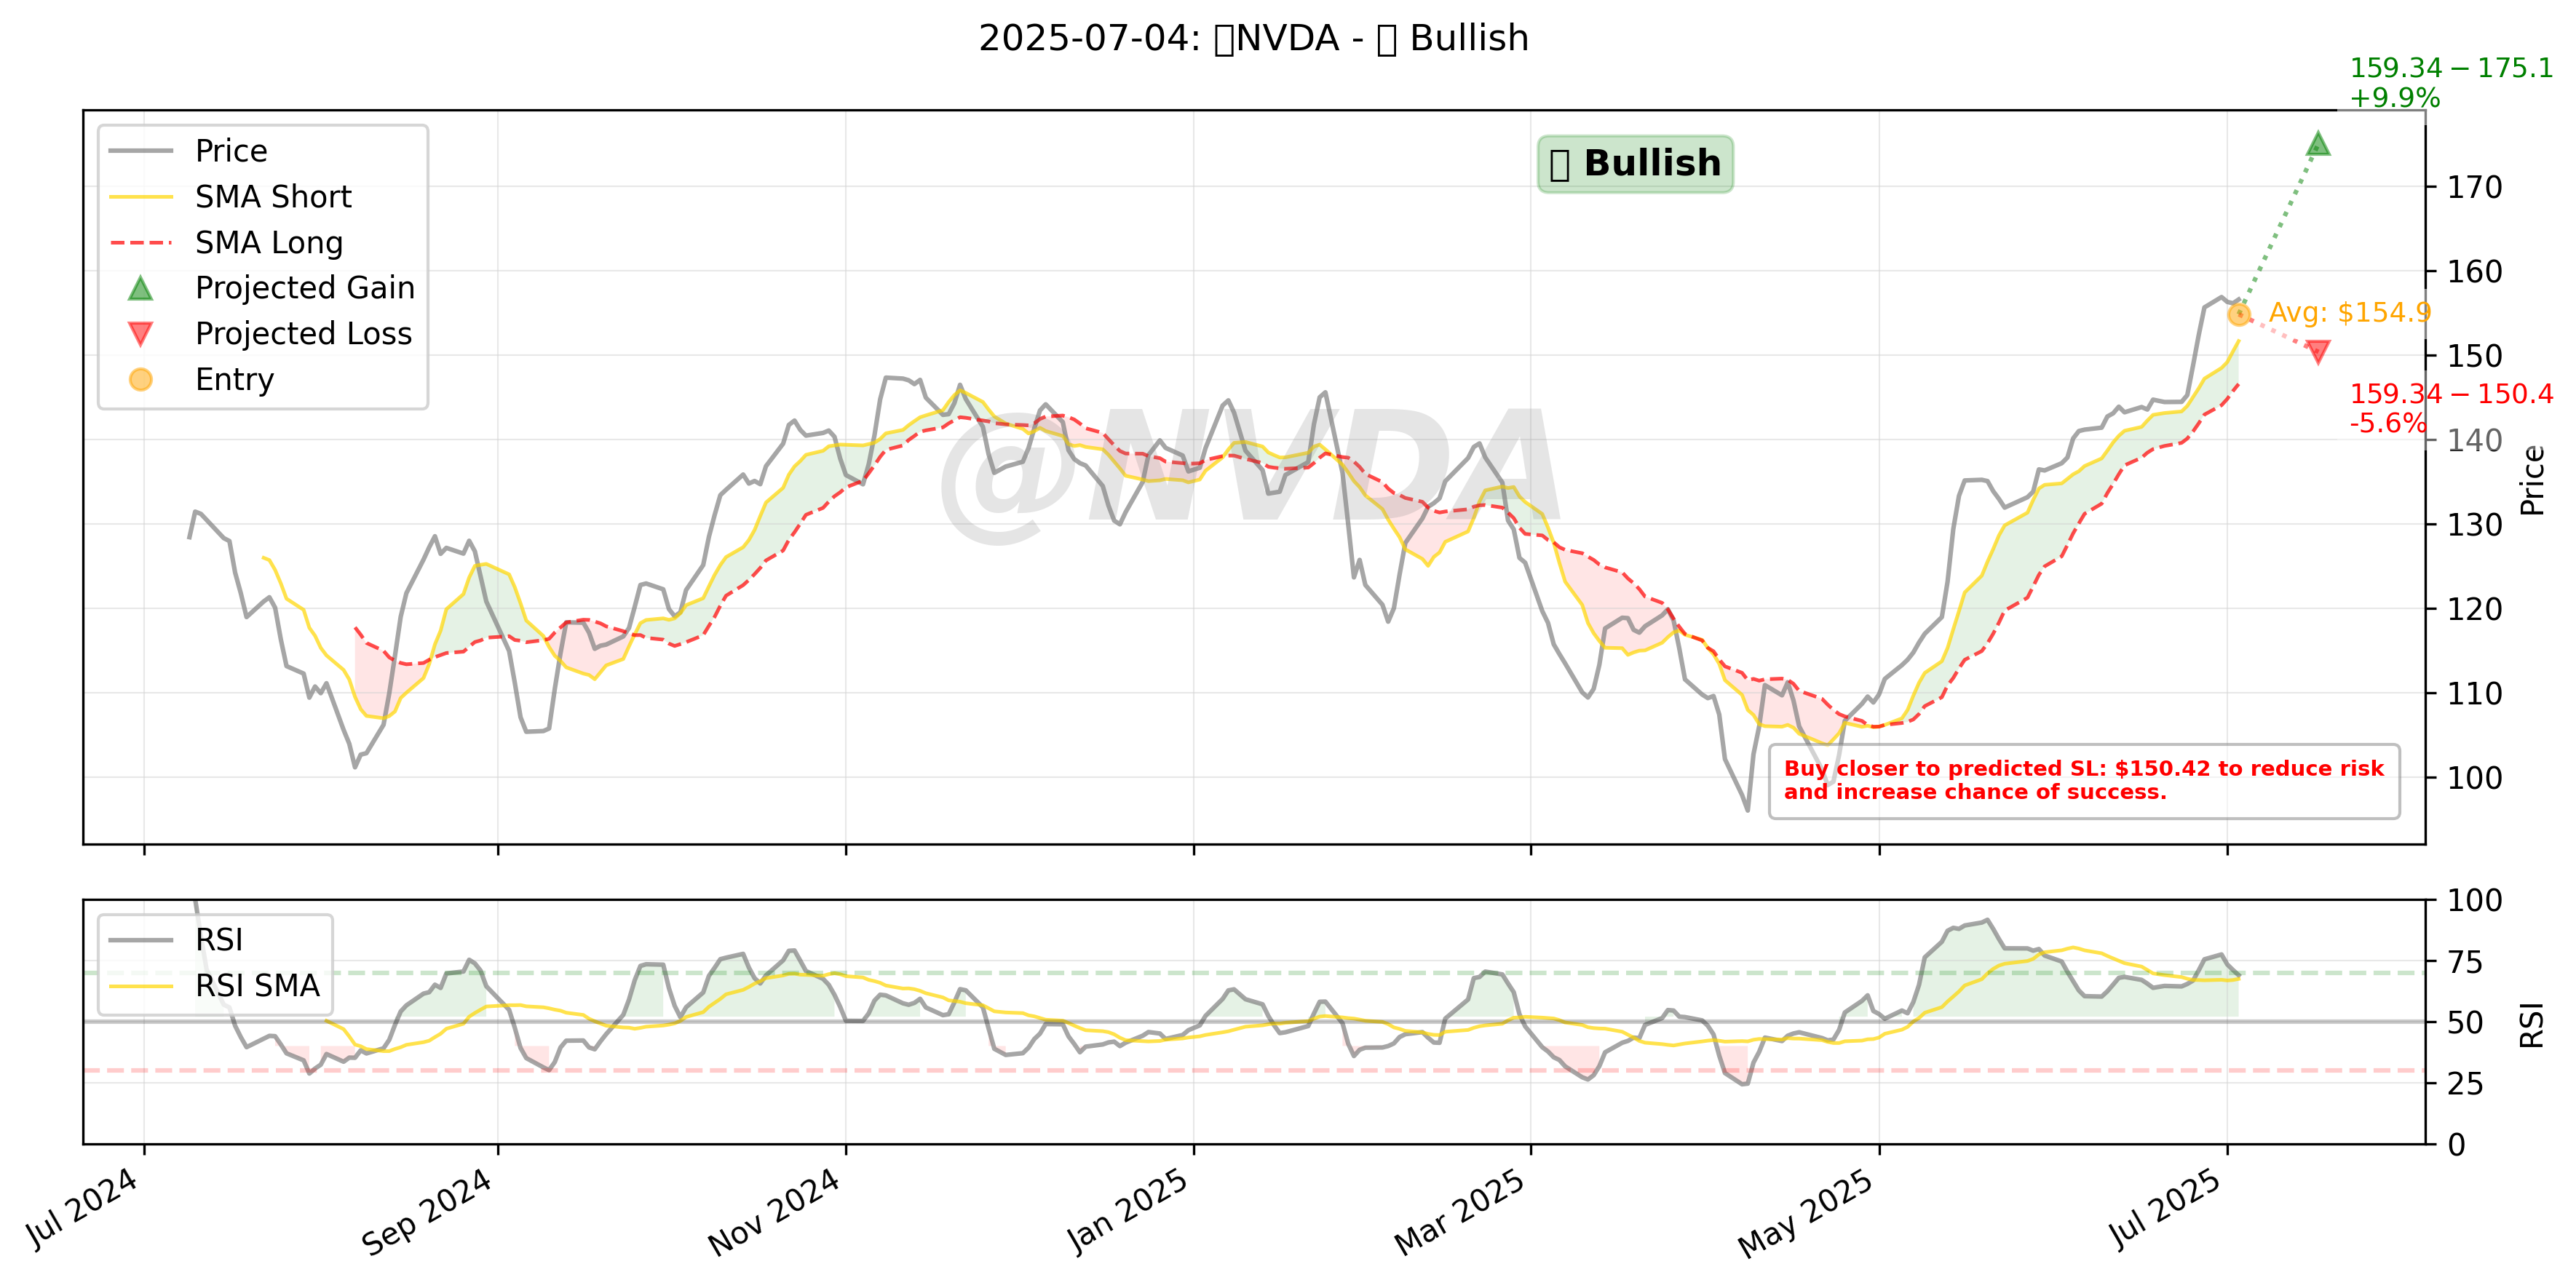

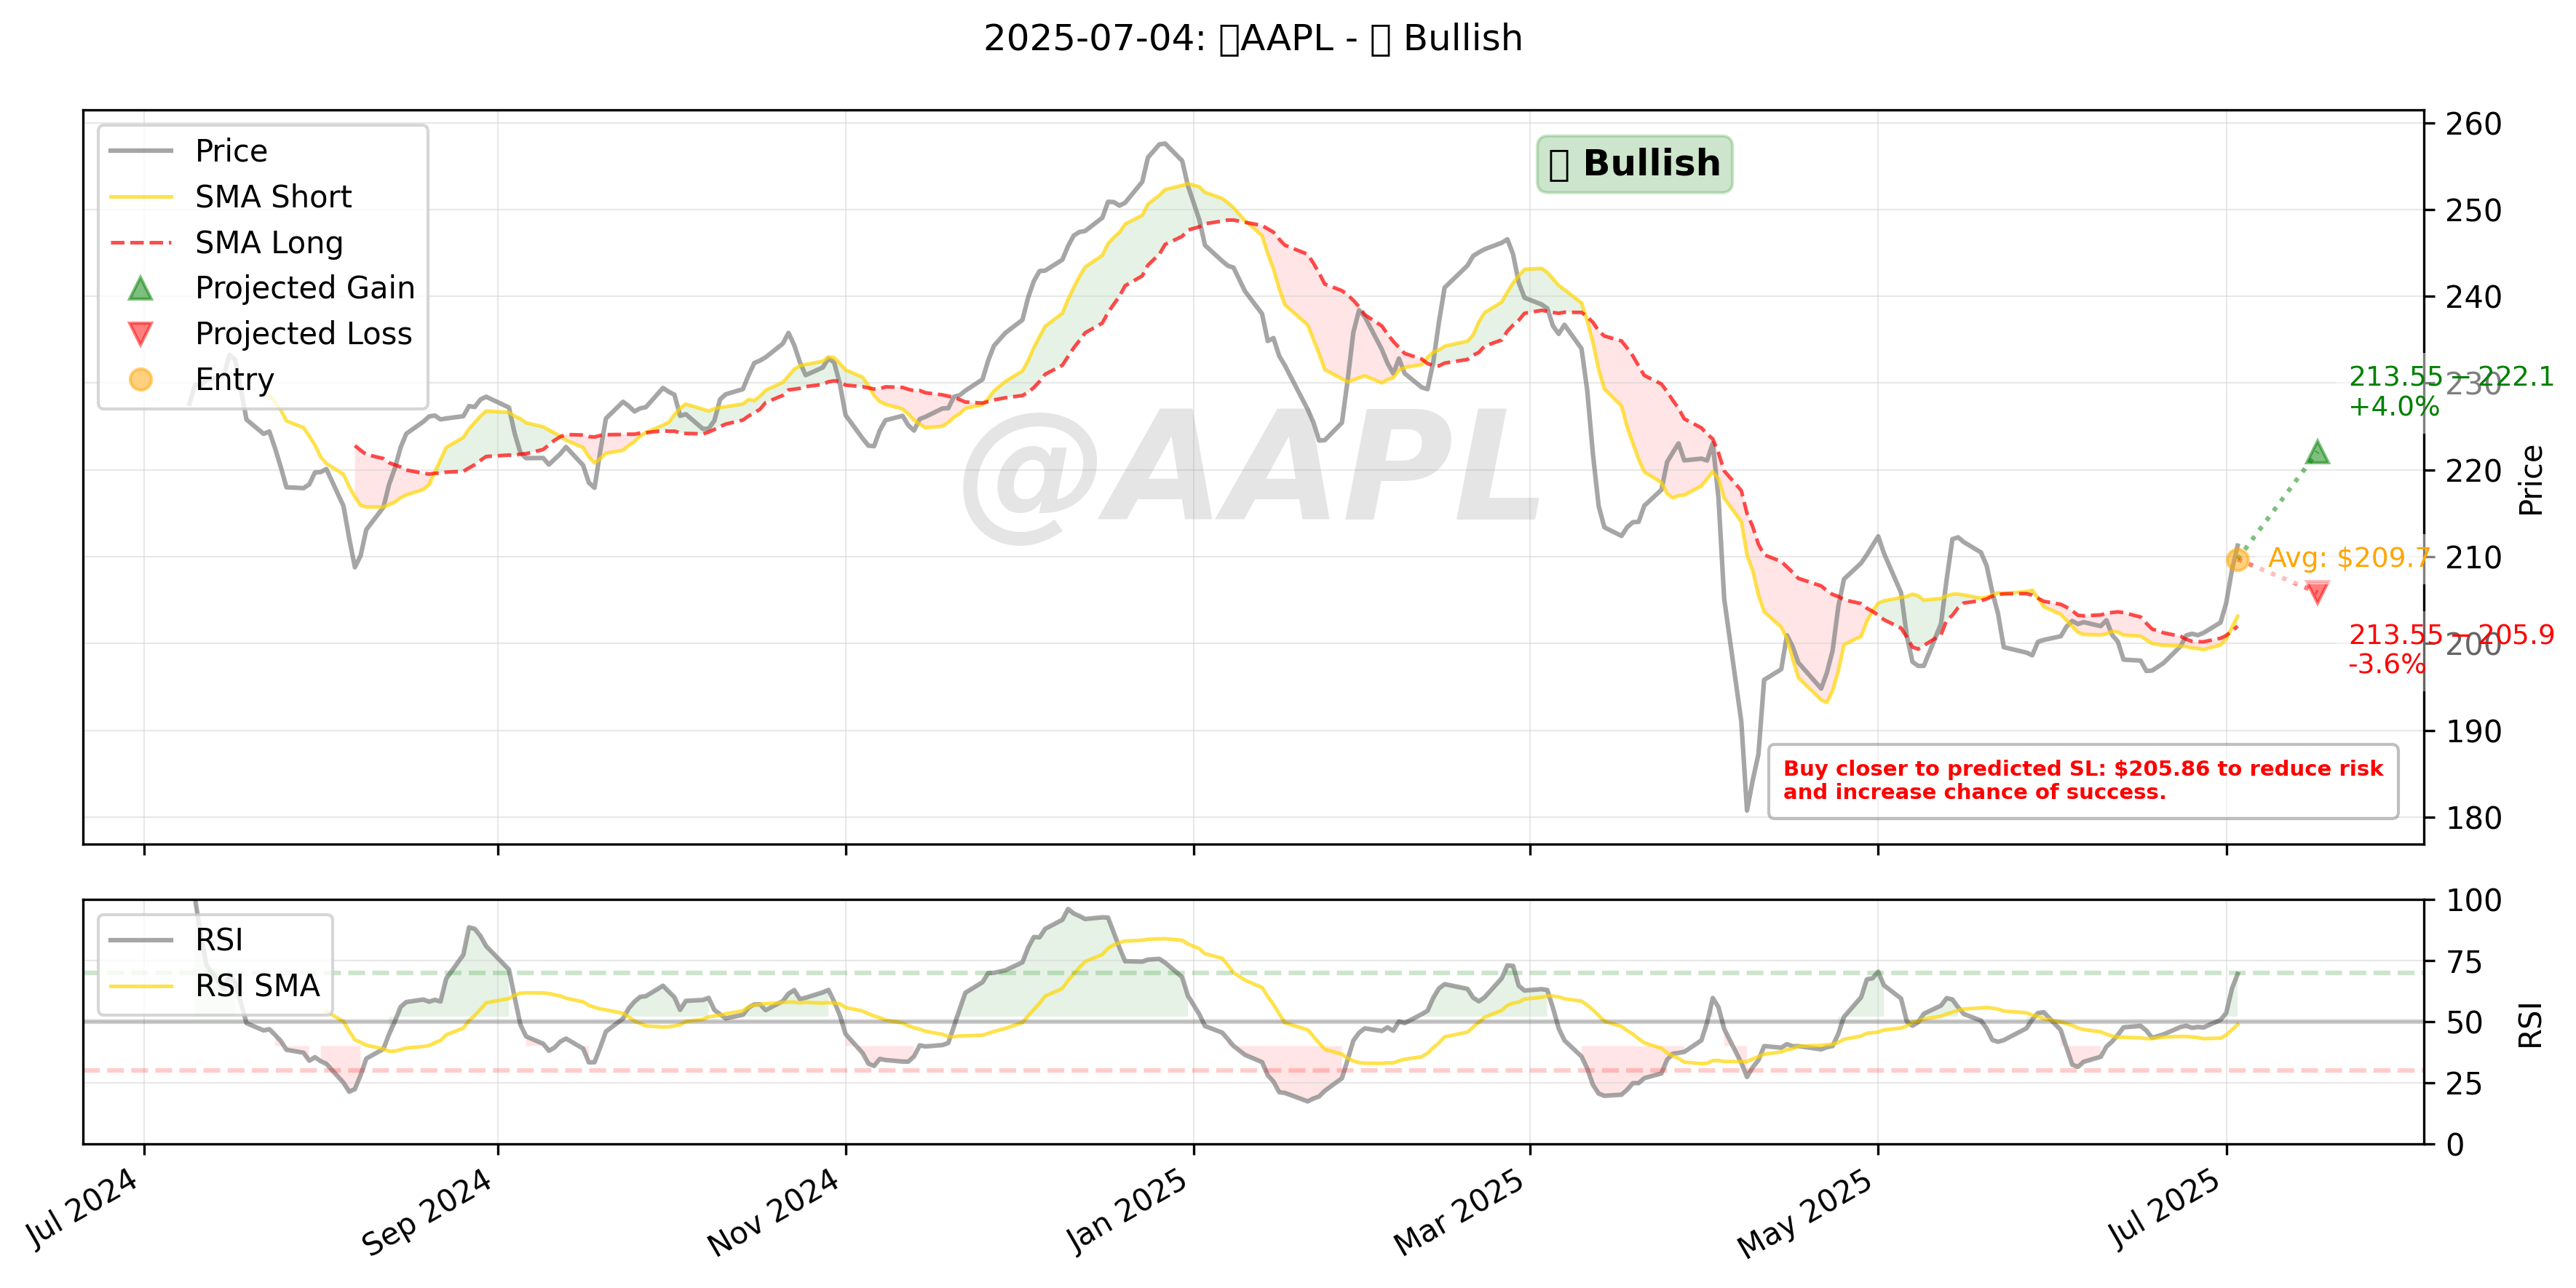

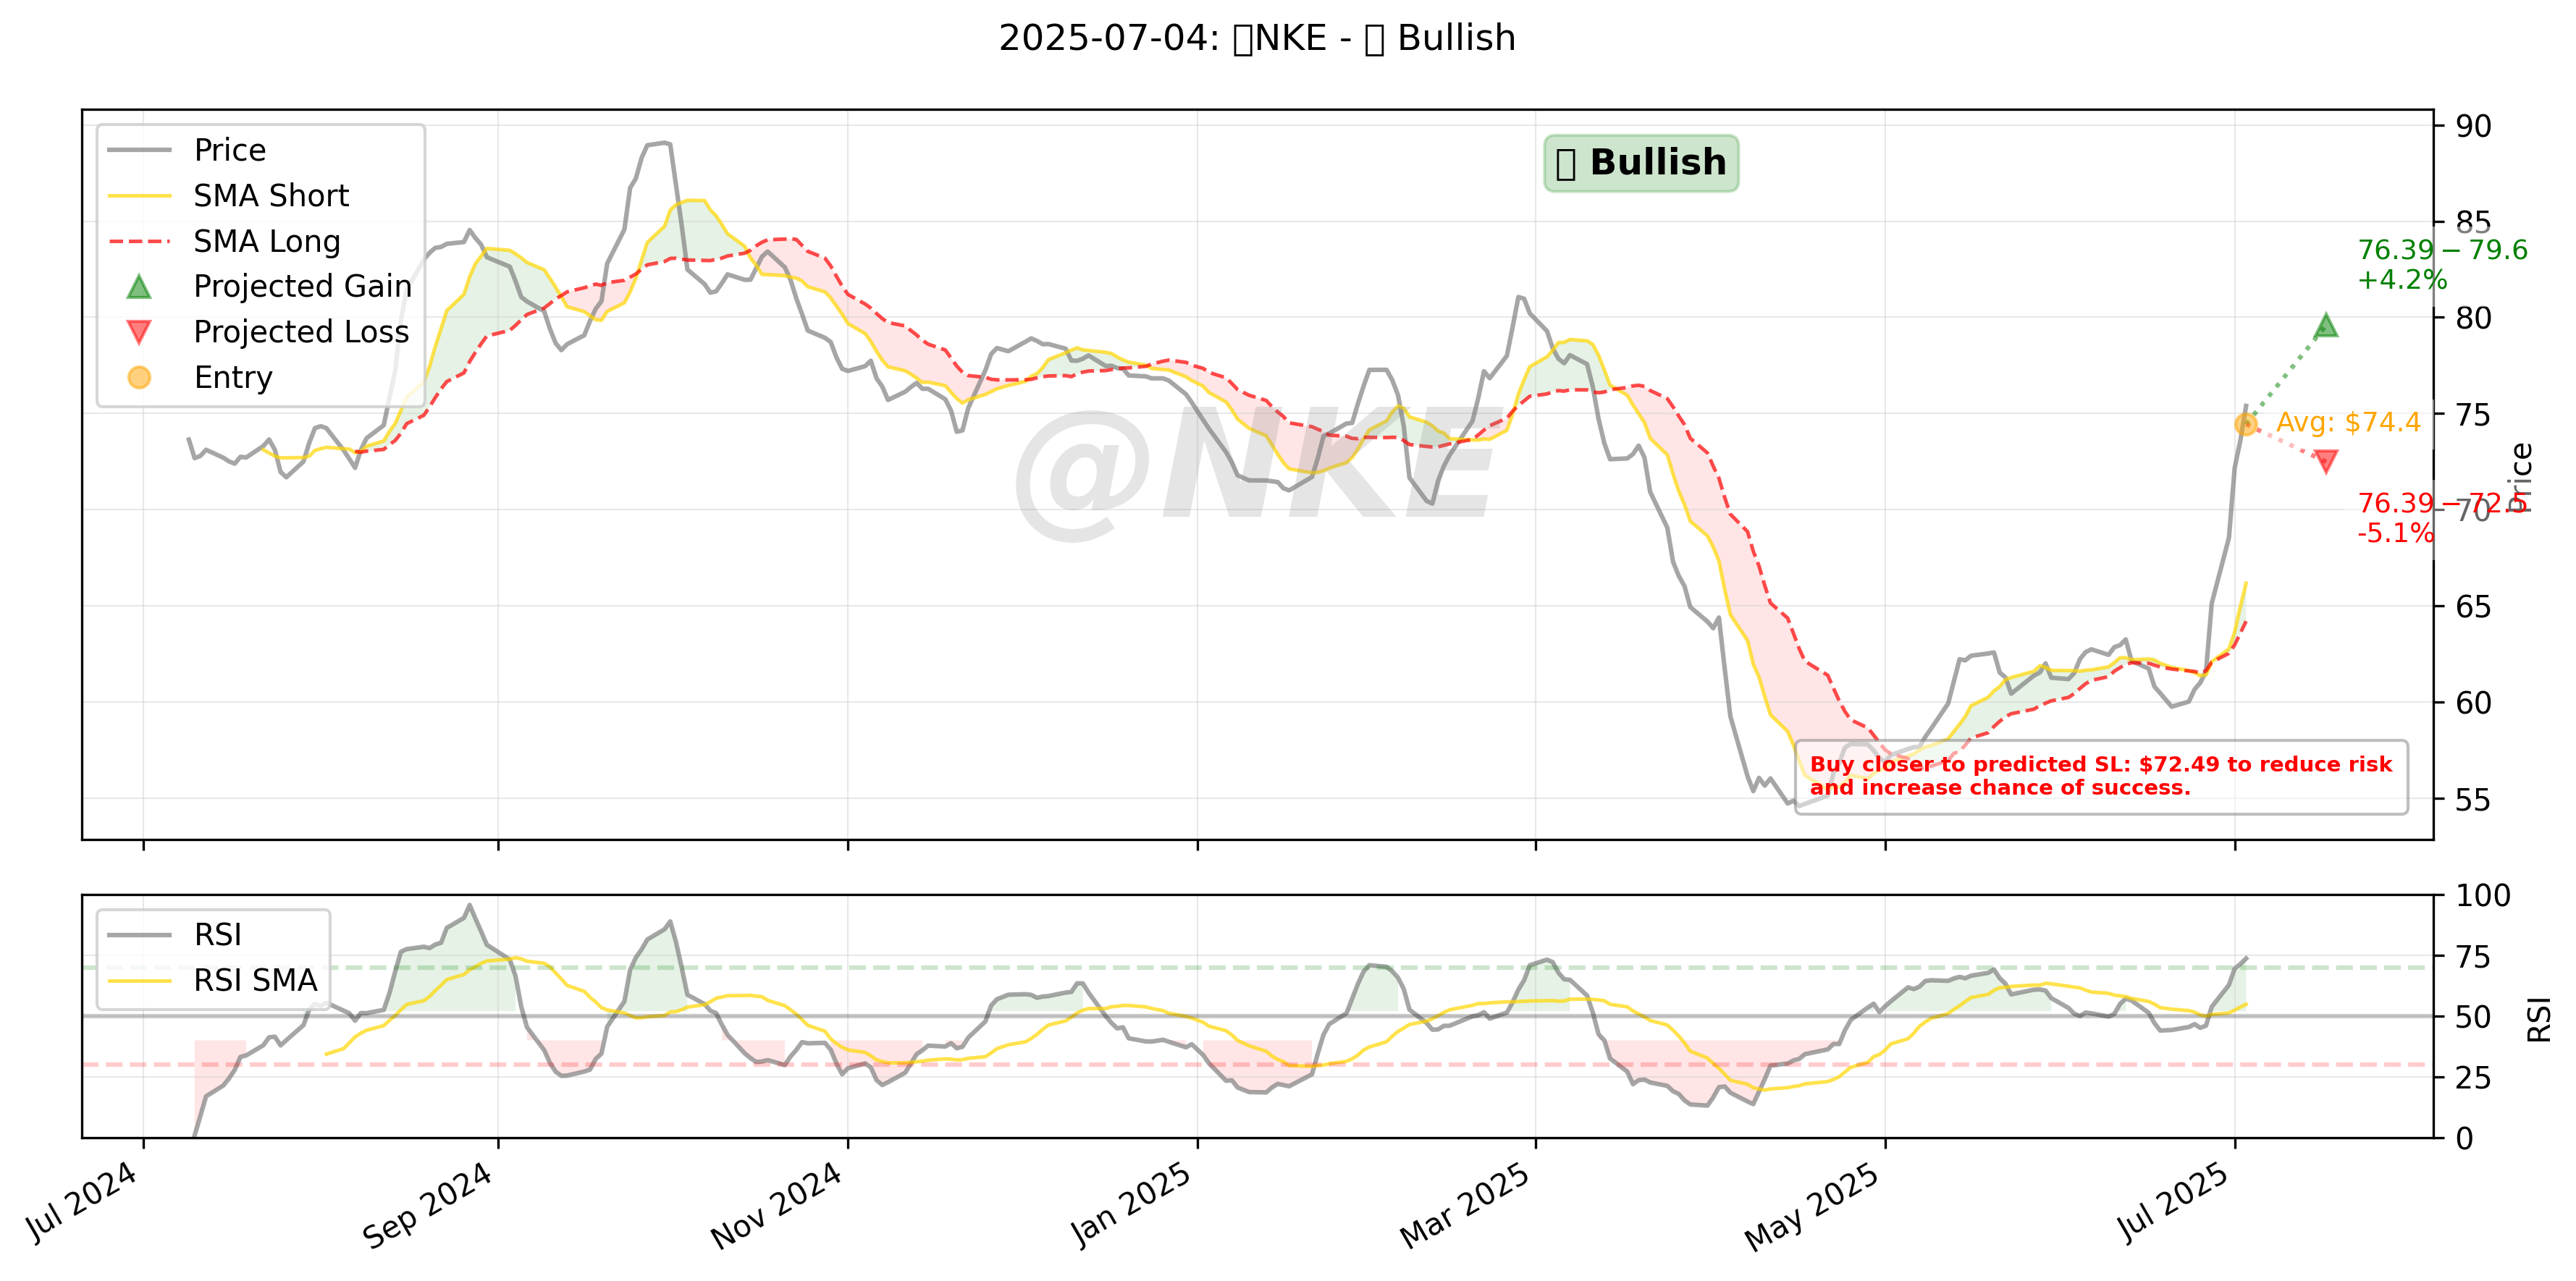

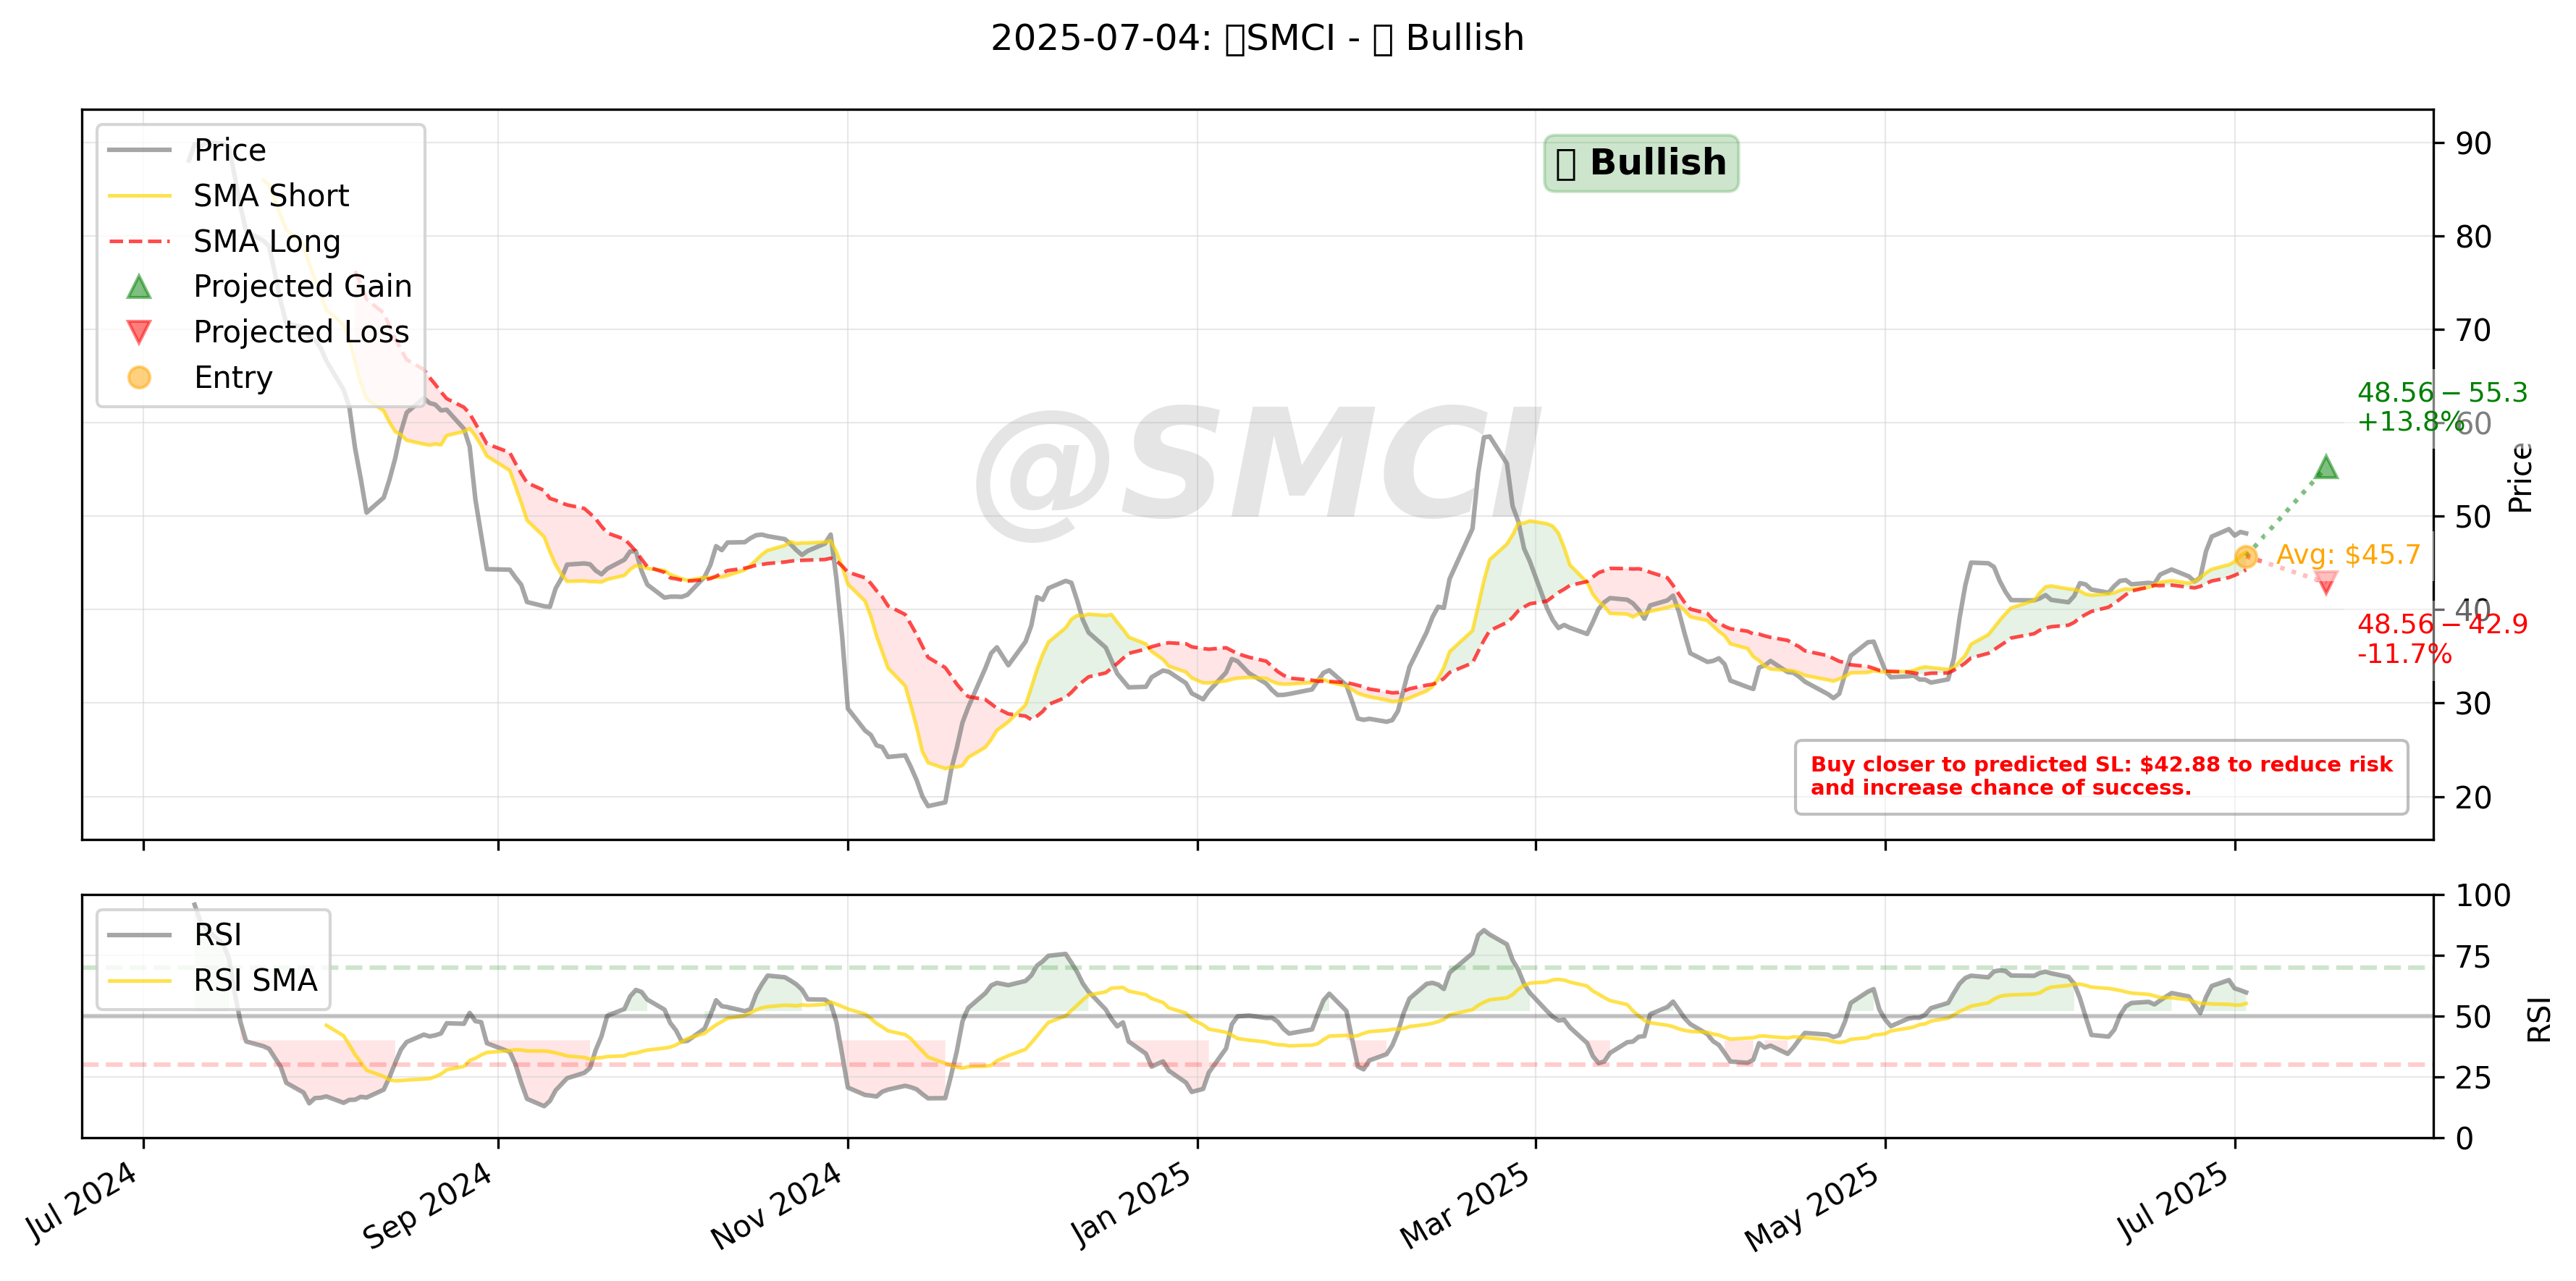

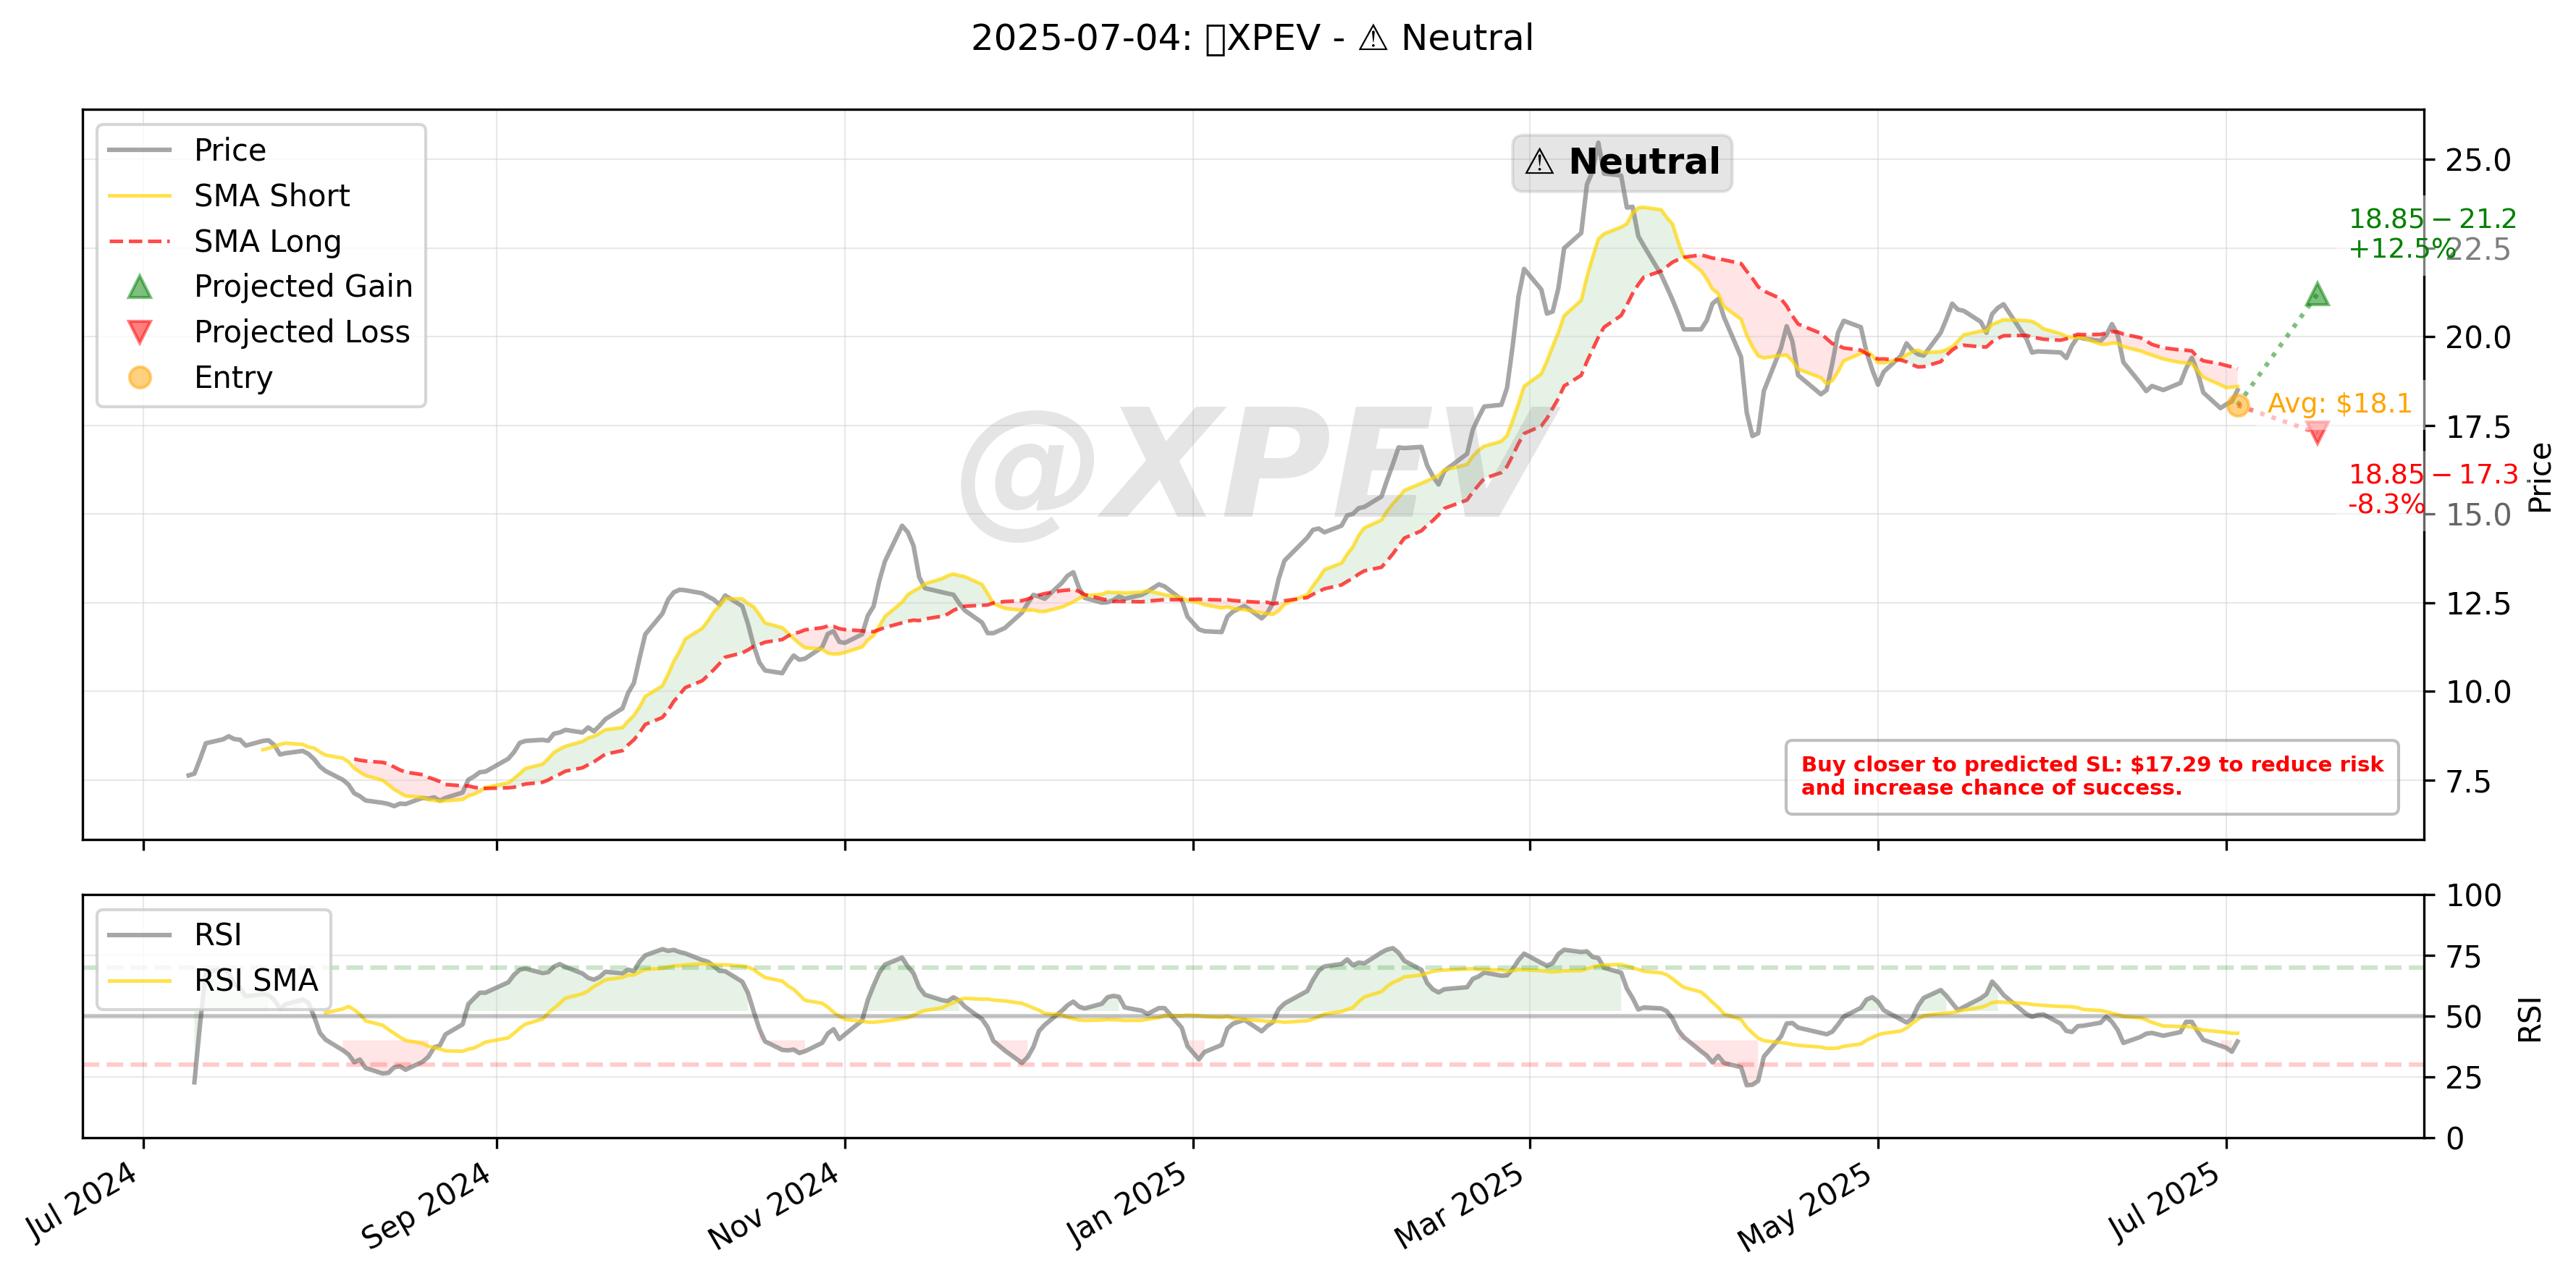

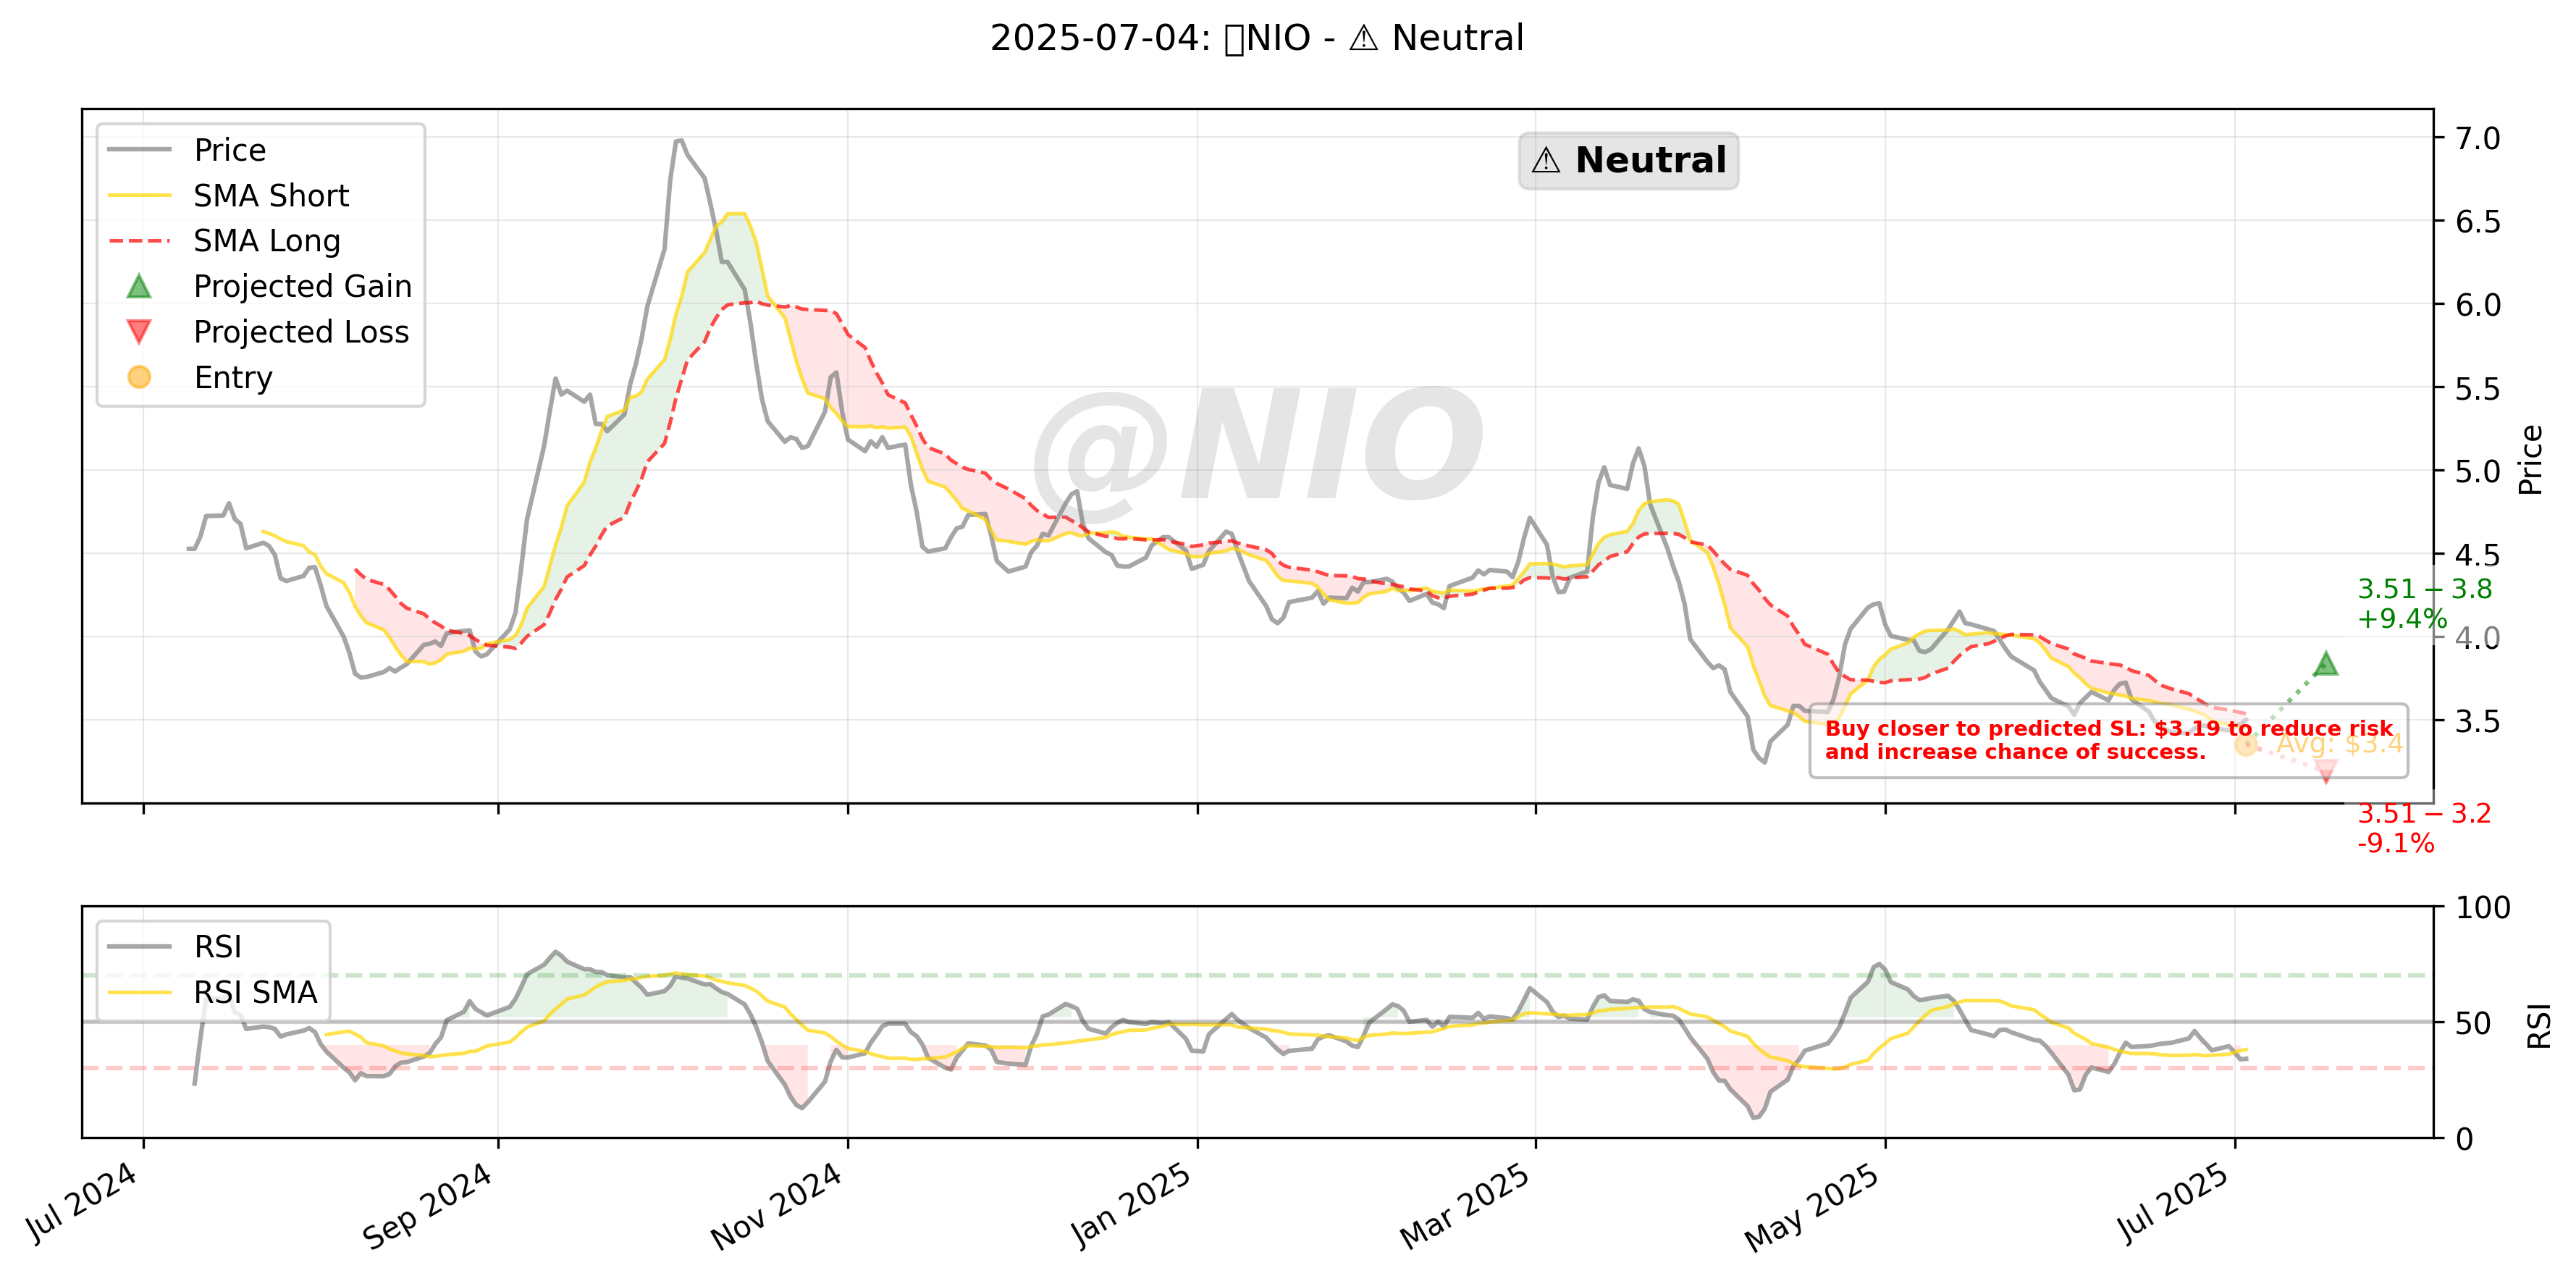

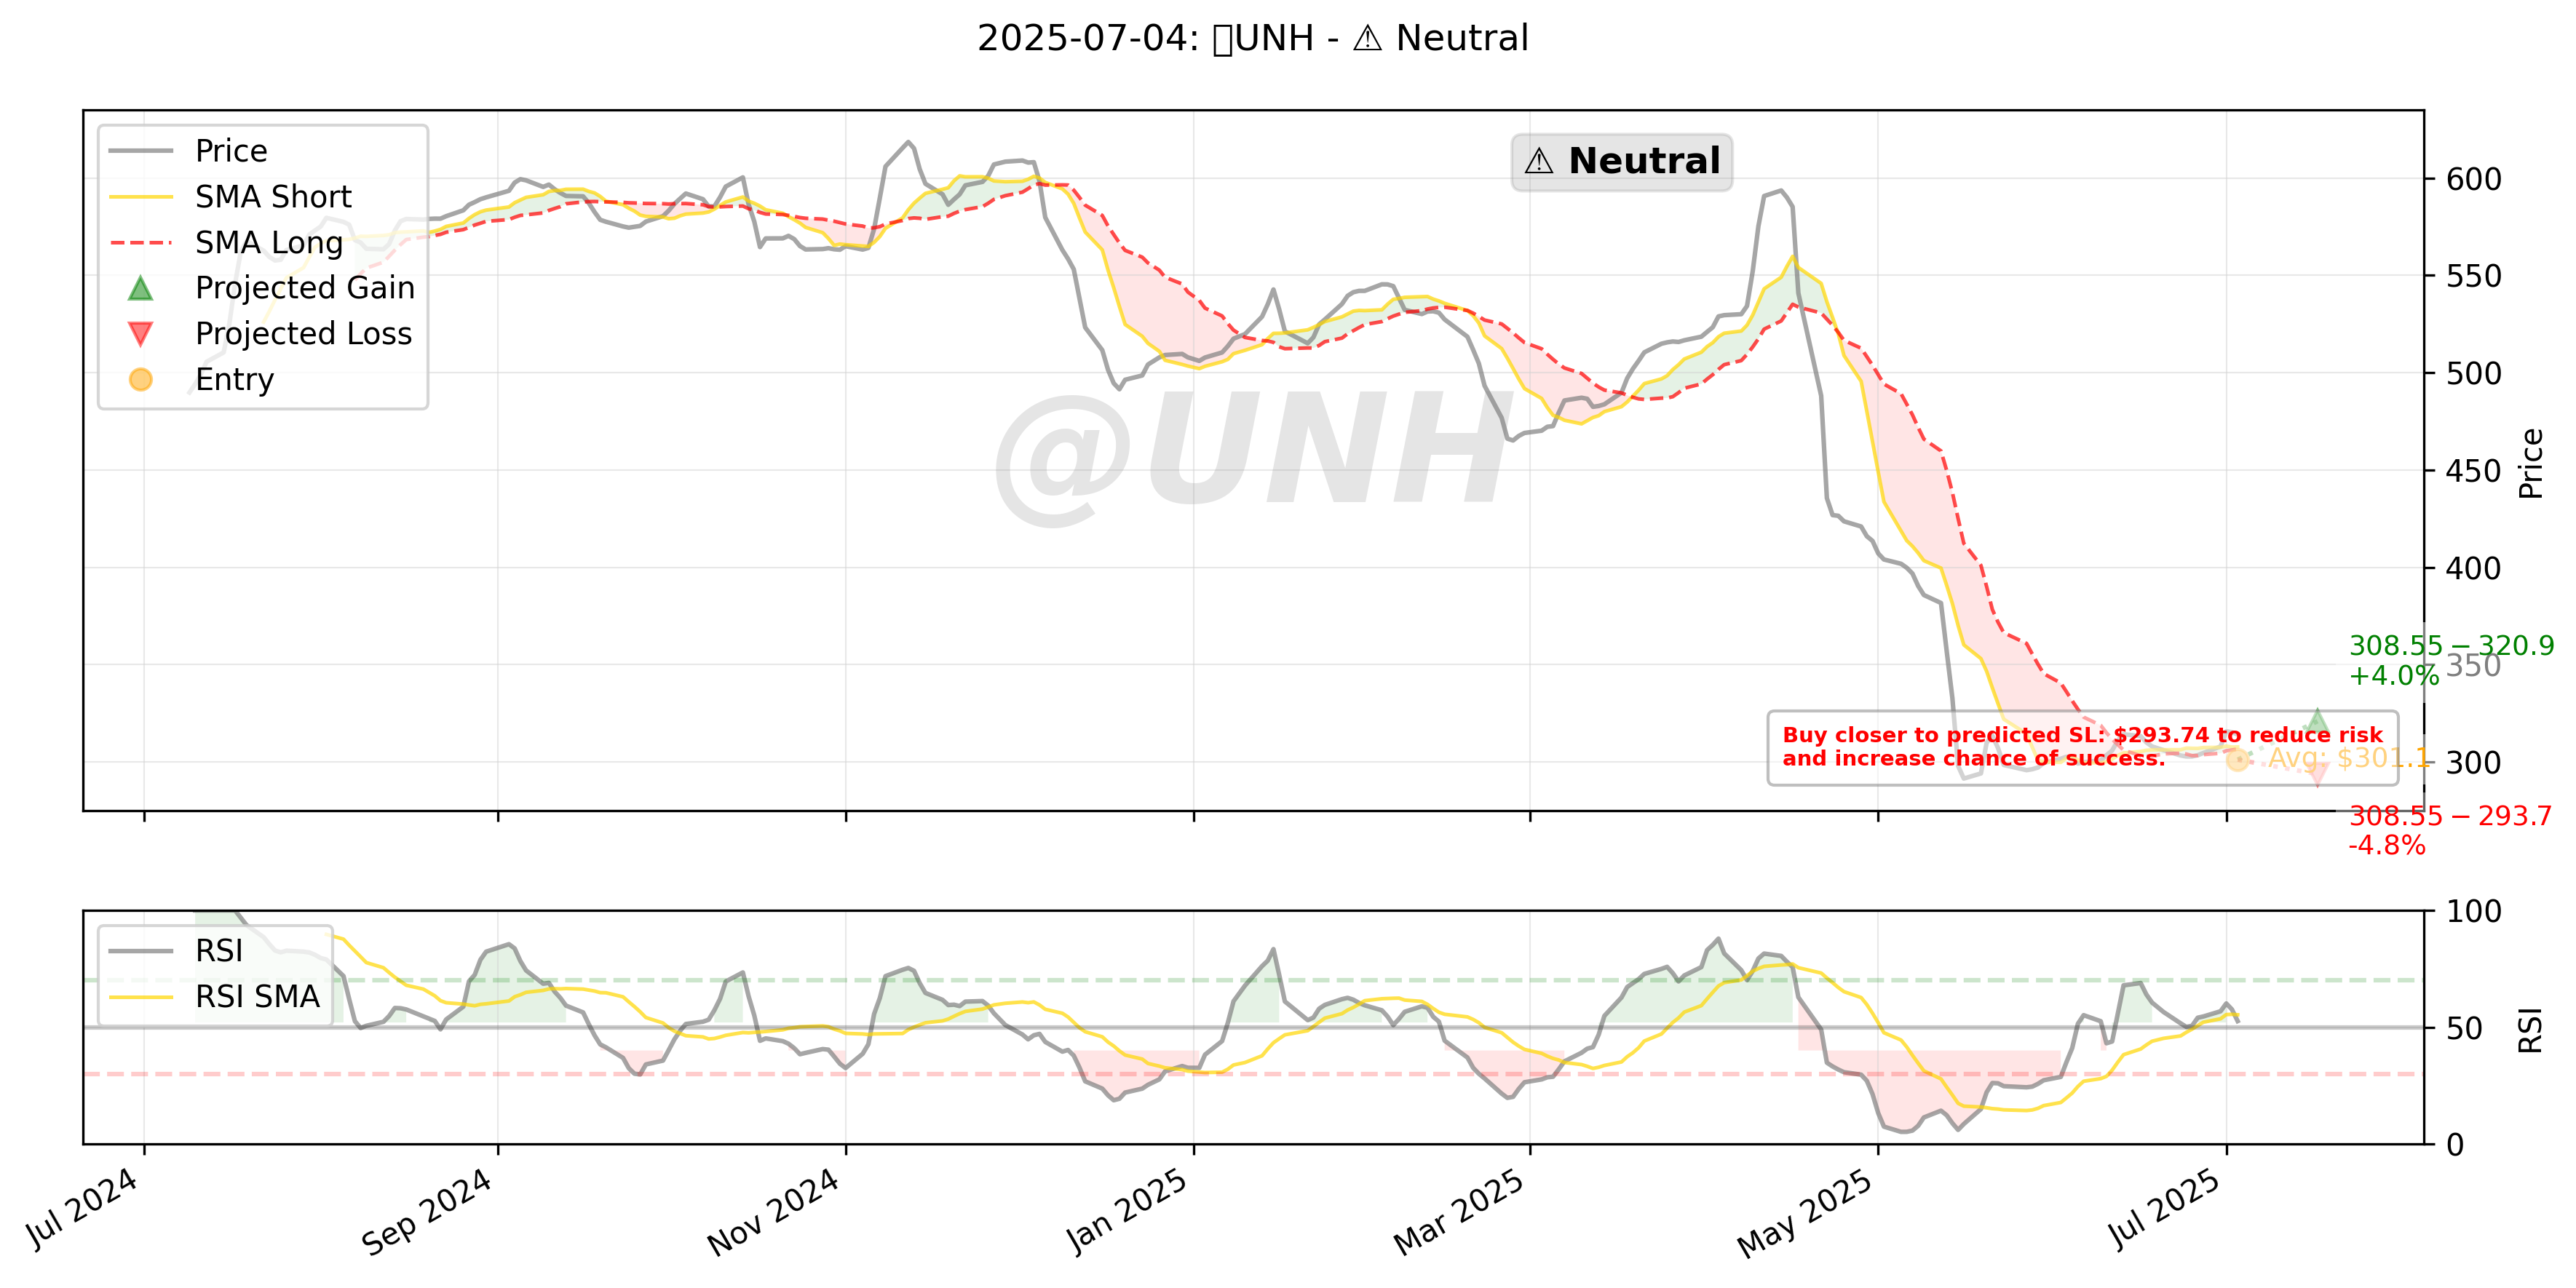

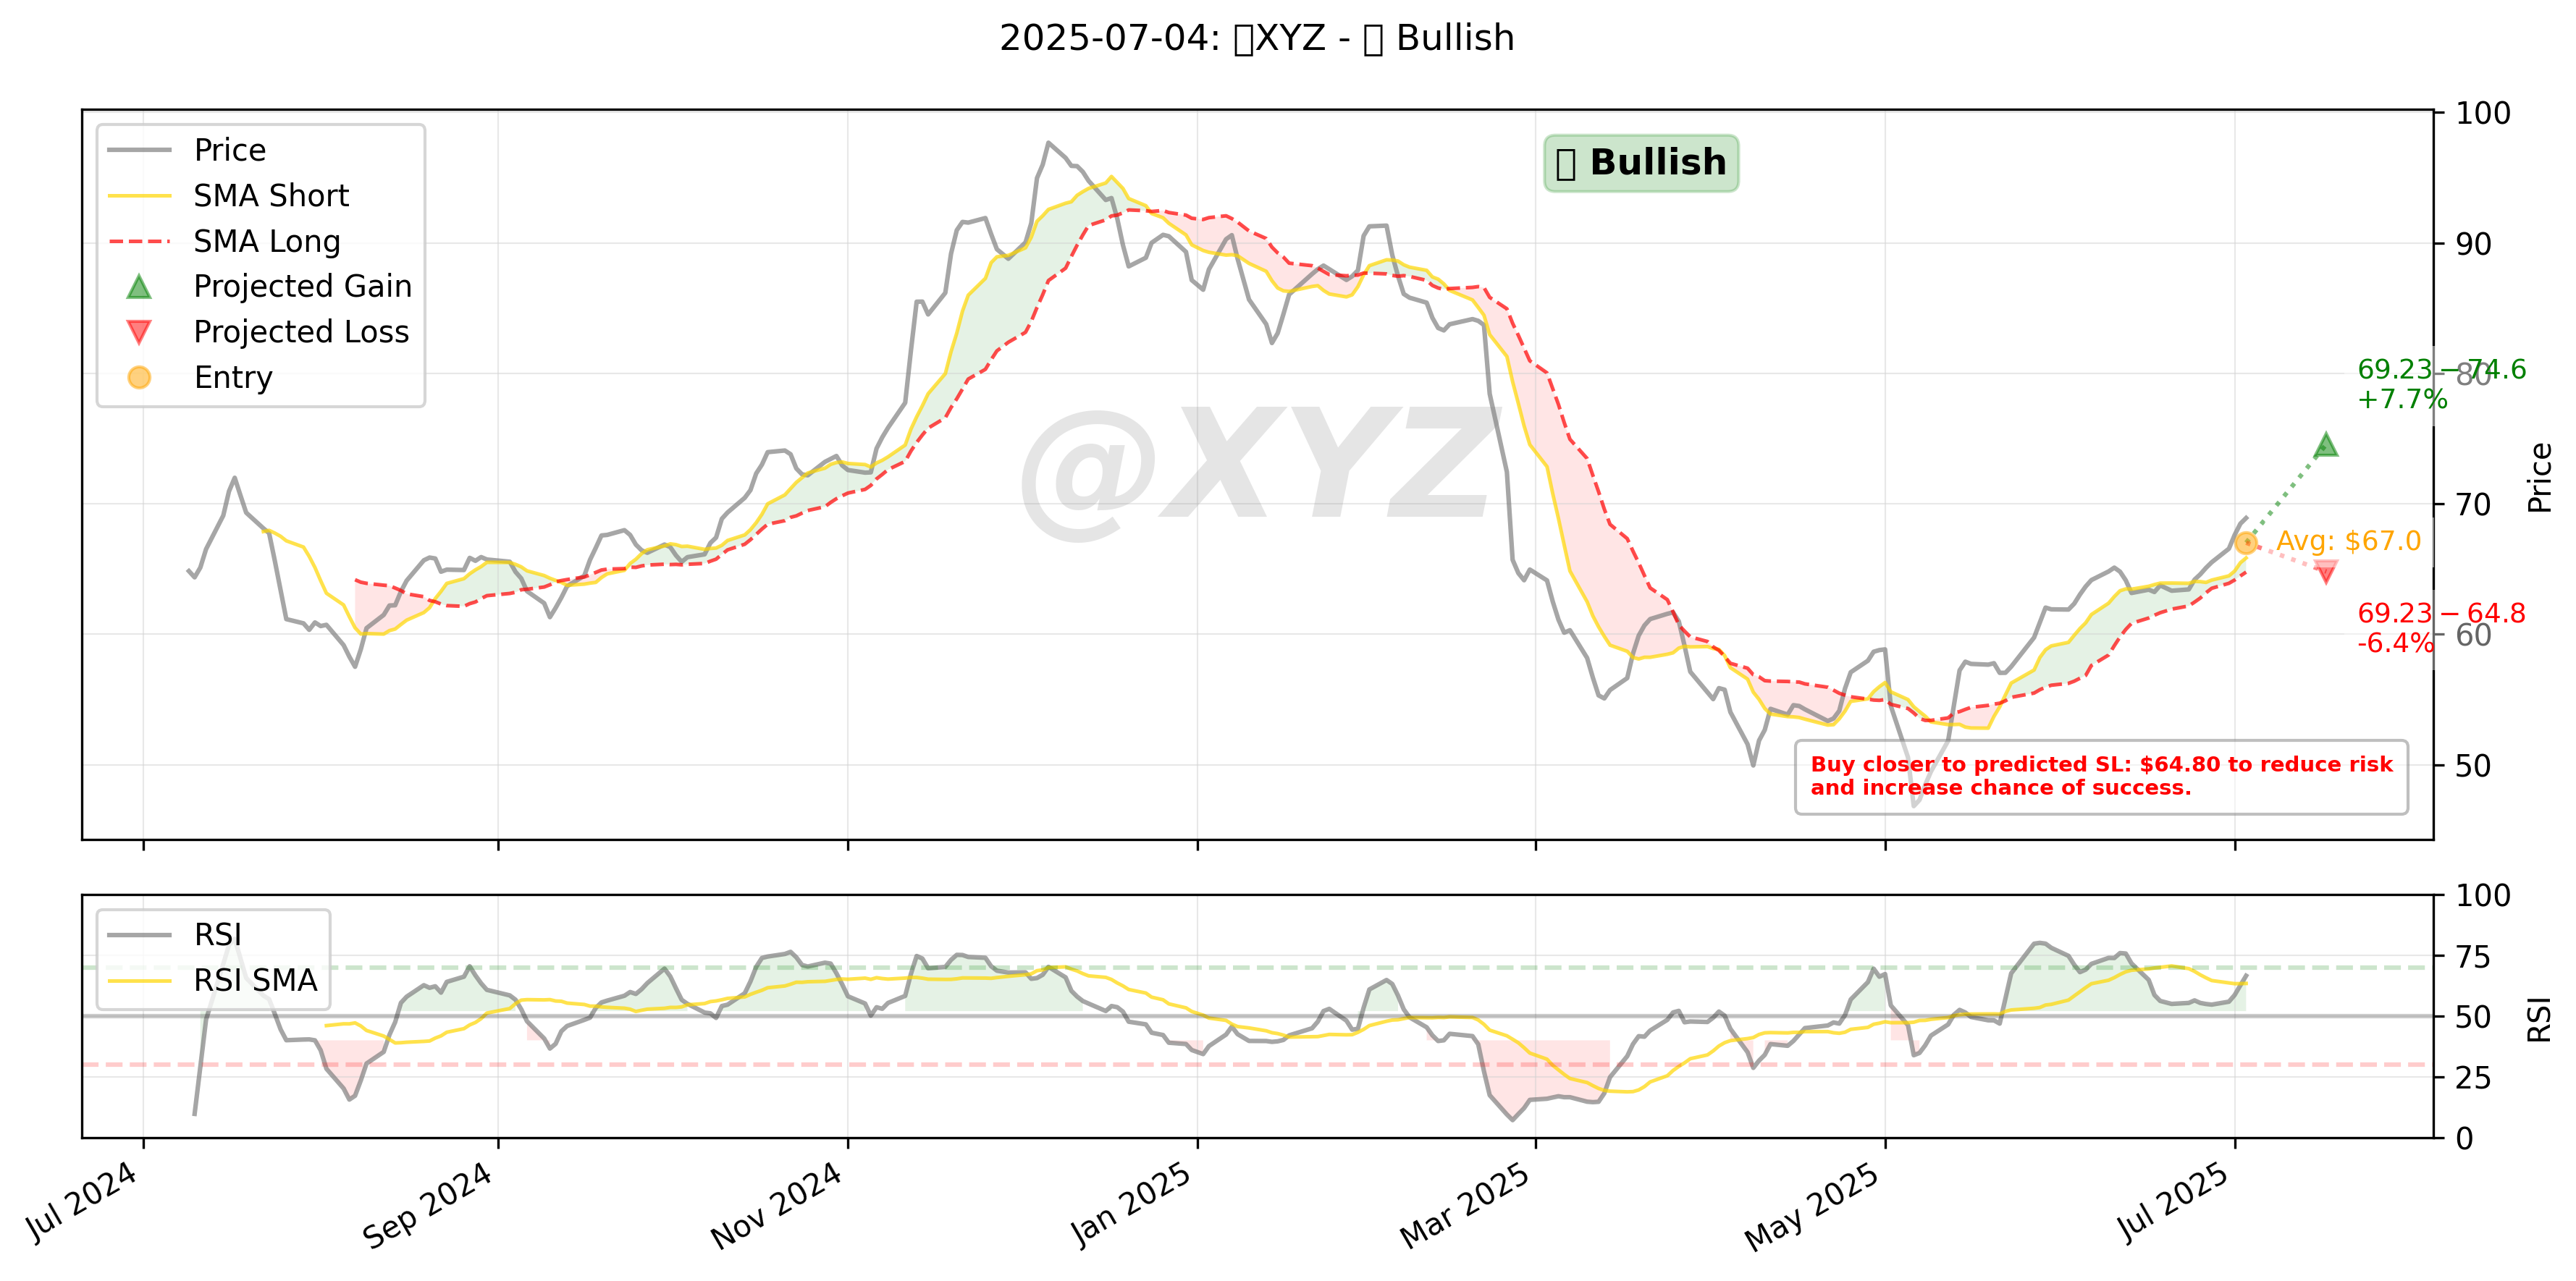

In [7]:
# PLOT STOCK TA with Predictions
for stock in TICKERS:
    df_ticker = get_stock_data(stock, datetime.now()-timedelta(days=365), datetime.now())
    df_ticker = add_technical_indicators(df_ticker)
    plot_single_ticker(stock, df_ticker, df_results)
    print("\n")

## TEST PROFITABILITY

Only trading when the price is (1Yr):

a) Above SMA20 days

b) RSI above 50

c) SMA20 > SMA50 days

d) SL is fixed like 3 to 5 %.

In [8]:
TICKERS = ["COIN", "TSLA", "GOOGL", "AAPL"]